In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


import antares_client

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# set random seed for consistent results
import random
random.seed(0)

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [2]:
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_90k_tns_df.csv', index_col='ztf_object_id')
dataset_bank_tns_df

,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,
ZTF20acpdyyq,No_TNS,None,-99.0,None
ZTF18acfvwwa,No_TNS,None,-99.0,None
ZTF17aaaskvj,No_TNS,None,-99.0,None
ZTF18aczbnhl,No_TNS,None,-99.0,None
ZTF18actbhqt,No_TNS,None,-99.0,None
...,...,...,...,...
ZTF18adairvu,No_TNS,None,-99.0,None
ZTF20aaiwhct,No_TNS,None,-99.0,None
ZTF20aberawv,No_TNS,None,-99.0,None


In [58]:
suffix=f"TNS-spec_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after_wLConly"

ann_num = 350
col_list= [f'dist={col}' for col in range(1, ann_num)]
dist_col = f'Max-{len(col_list)}ANNs'


ann_dist_all_df = pd.read_csv(f'ann_dist_all_df_{suffix}_ann_num={ann_num}.csv', index_col=0)
ann_dist_all_df.index = ann_dist_all_df.index.rename('ztf_object_id')
ann_dist_all_df

,Mean-349ANNs,Max-349ANNs
ztf_object_id,,
ZTF18aabeszt,5665.038096,6757.778809
ZTF18aacnlxz,6608.969012,8667.017578
ZTF18aadlaxo,6333.570990,7628.583008
ZTF18aadsuxd,6437.597669,7554.719727
ZTF18aafzers,8360.640333,9913.776367
...,...,...
ZTF21acipbwd,7459.016126,8757.175781
ZTF21aciuhqw,7492.123176,8751.051758
ZTF21ackbbfs,6422.131139,7535.736328


In [59]:
merge_df = pd.concat([ann_dist_all_df, dataset_bank_tns_df], axis=1)
merge_df = merge_df[~merge_df.isnull().any(axis=1)]
merge_df

,Mean-349ANNs,Max-349ANNs,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,
ZTF18aabeszt,5665.038096,6757.778809,Yes_TNS,SN Ia,0.081000,ALeRCE
ZTF18aacnlxz,6608.969012,8667.017578,Yes_TNS,SN II,0.072475,ZTF
ZTF18aadlaxo,6333.570990,7628.583008,Yes_TNS,SN Ia,0.052953,ZTF
ZTF18aadsuxd,6437.597669,7554.719727,Yes_TNS,SN II,0.030570,ZTF
ZTF18aafzers,8360.640333,9913.776367,Yes_TNS,SN Ia-pec,0.048708,ALeRCE
...,...,...,...,...,...,...
ZTF21acipbwd,7459.016126,8757.175781,Yes_TNS,SN Ia,0.094000,YSE
ZTF21aciuhqw,7492.123176,8751.051758,Yes_TNS,SN Ic-BL,0.045000,ZTF
ZTF21ackbbfs,6422.131139,7535.736328,Yes_TNS,SN Ia,0.045000,AMPEL


In [60]:
MO_df = merge_df[(merge_df[dist_col]>=4000) & (merge_df.has_tns == 'No_TNS')]

for sn in MO_df.index:
    print(f'https://alerce.online/object/{sn}')

<ipython-input-61-03ac10b41d7a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


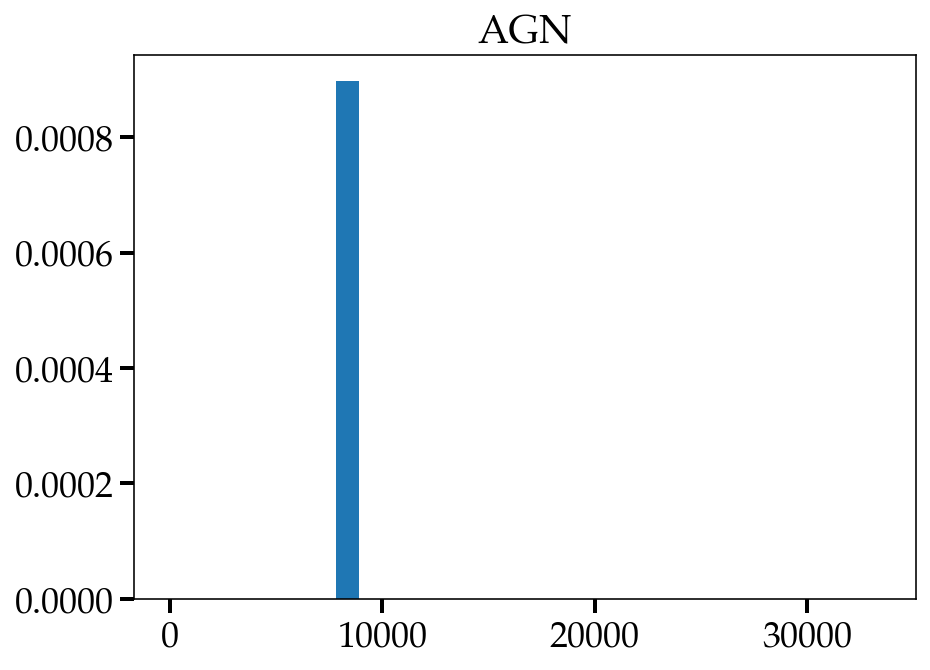

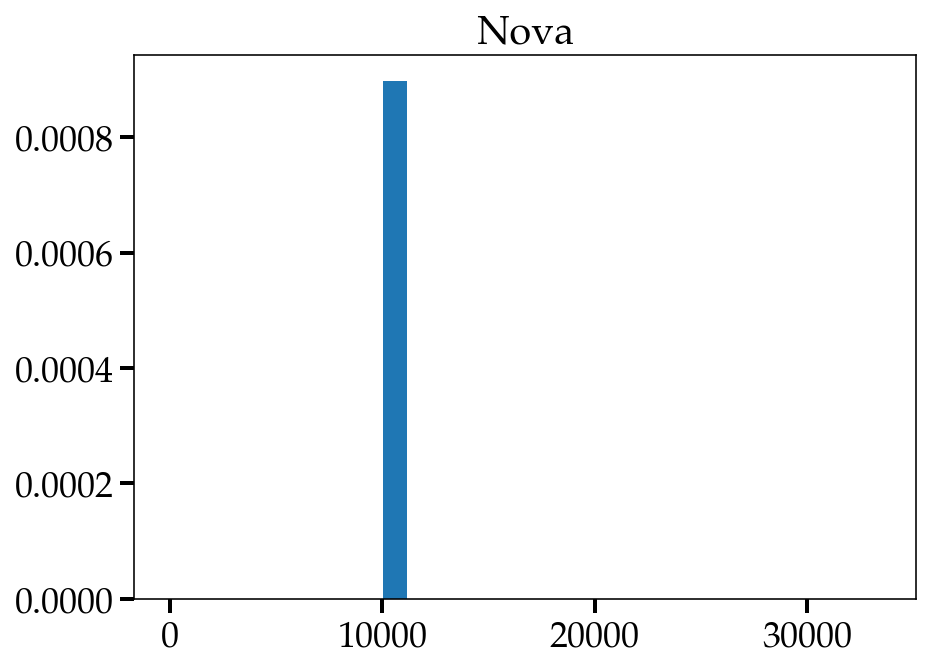

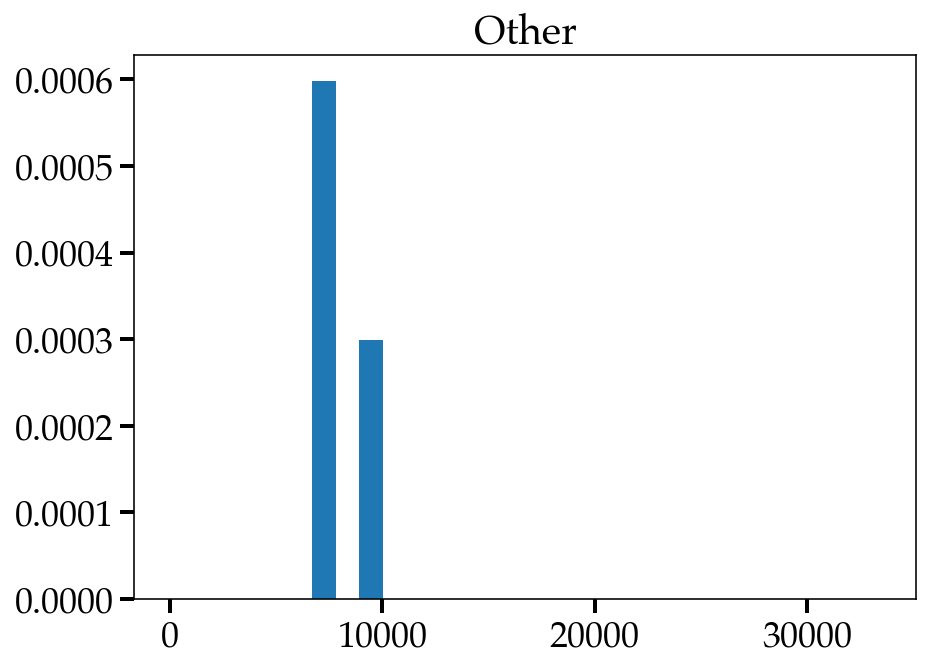

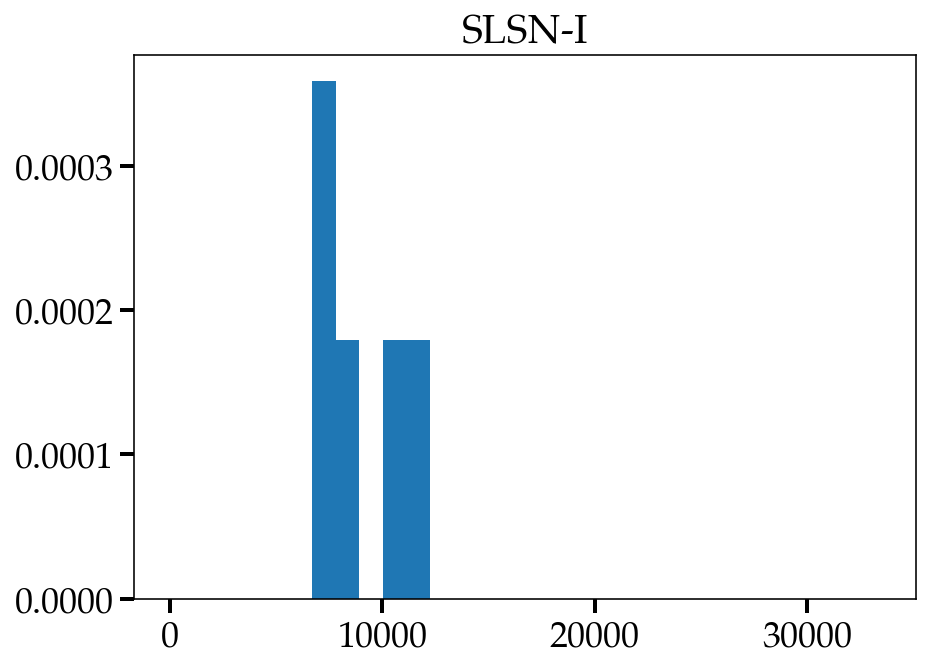

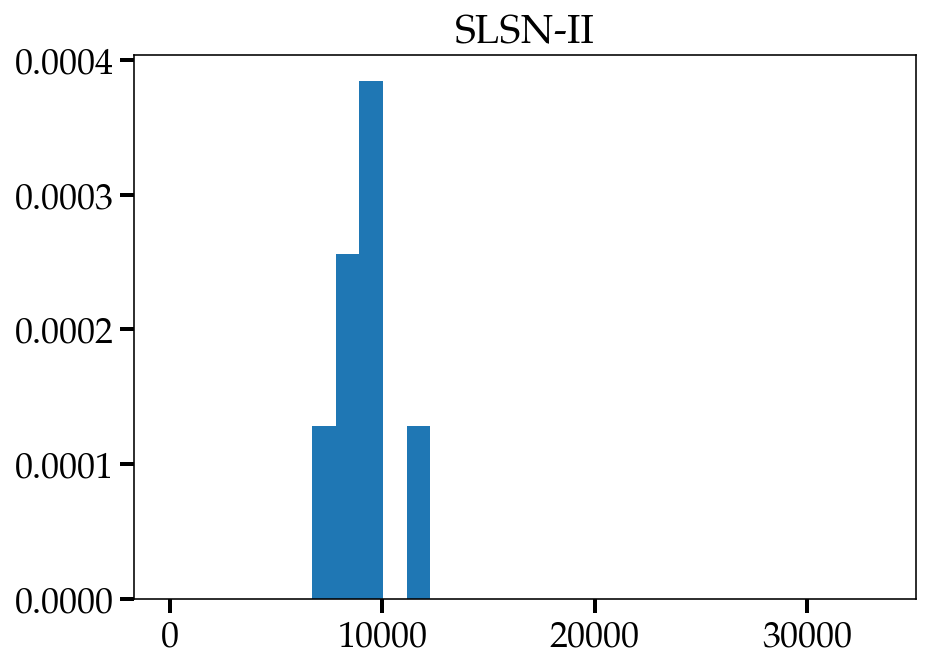

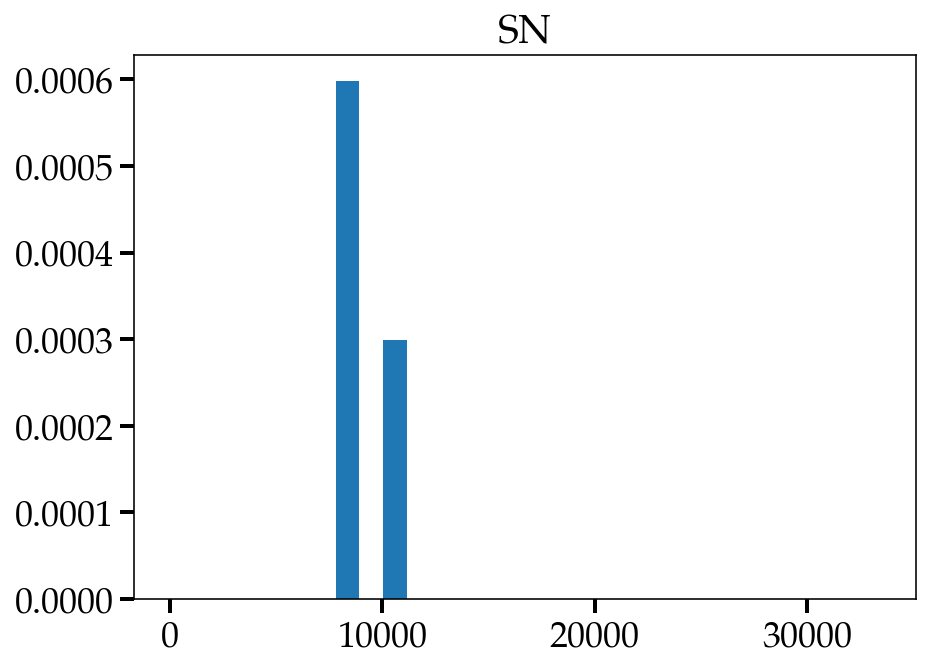

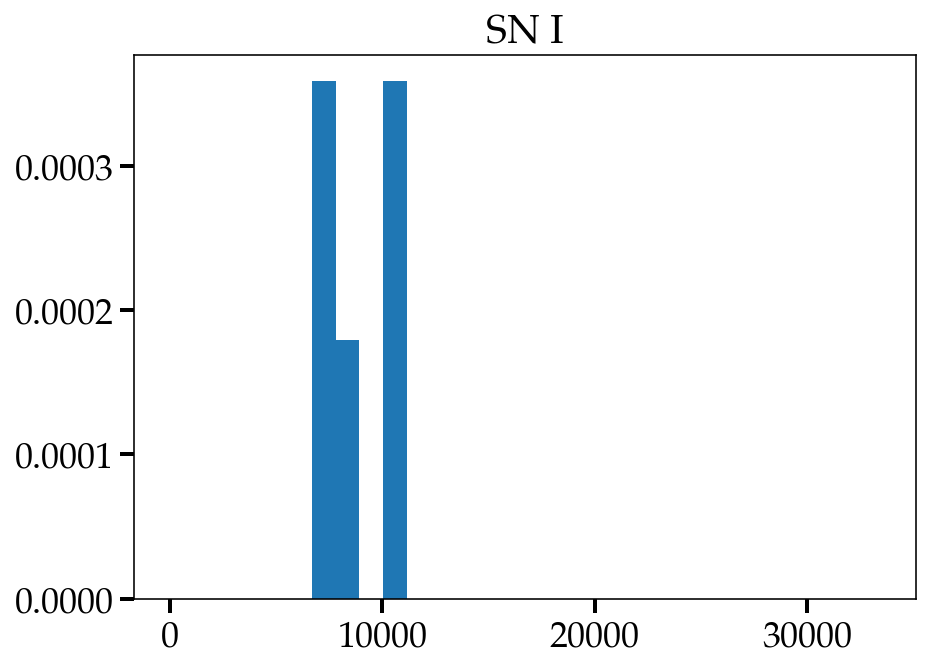

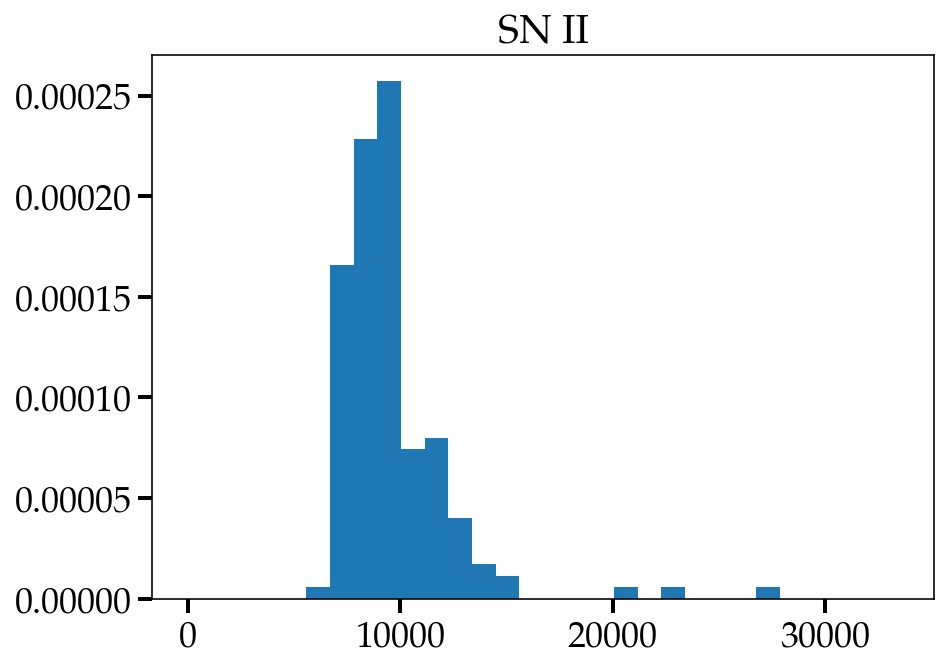

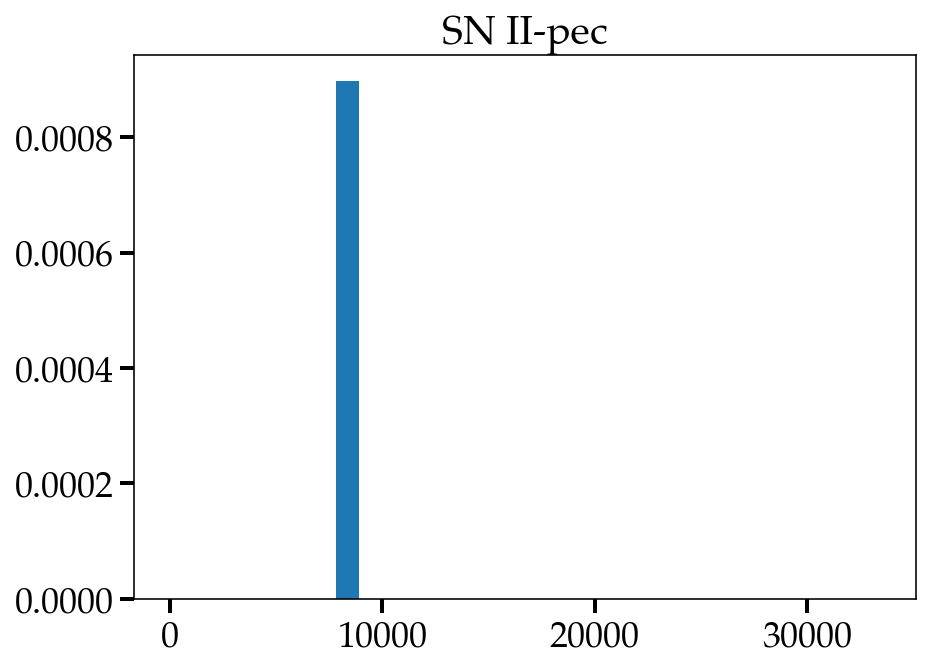

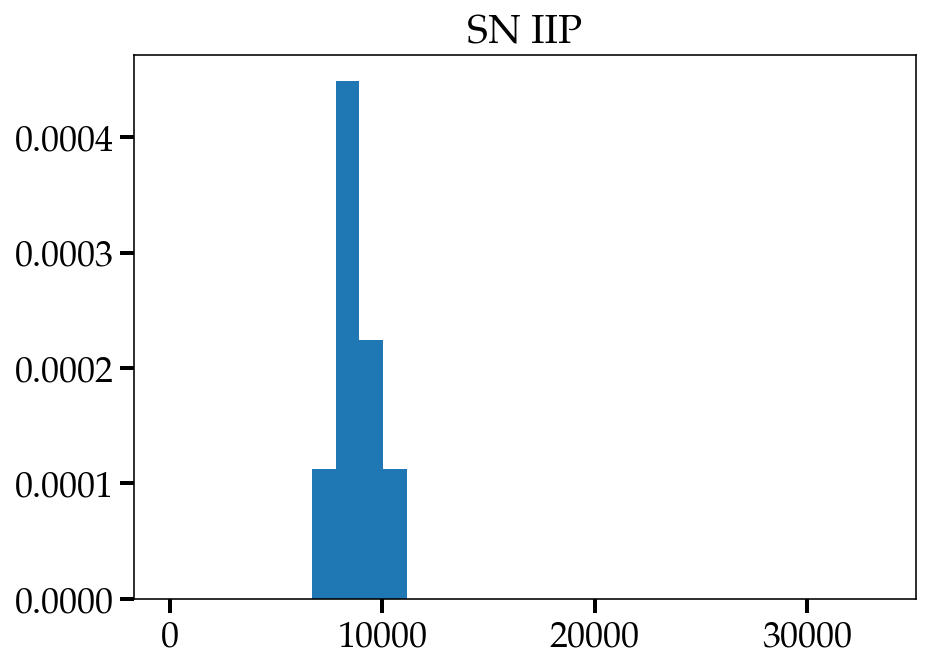

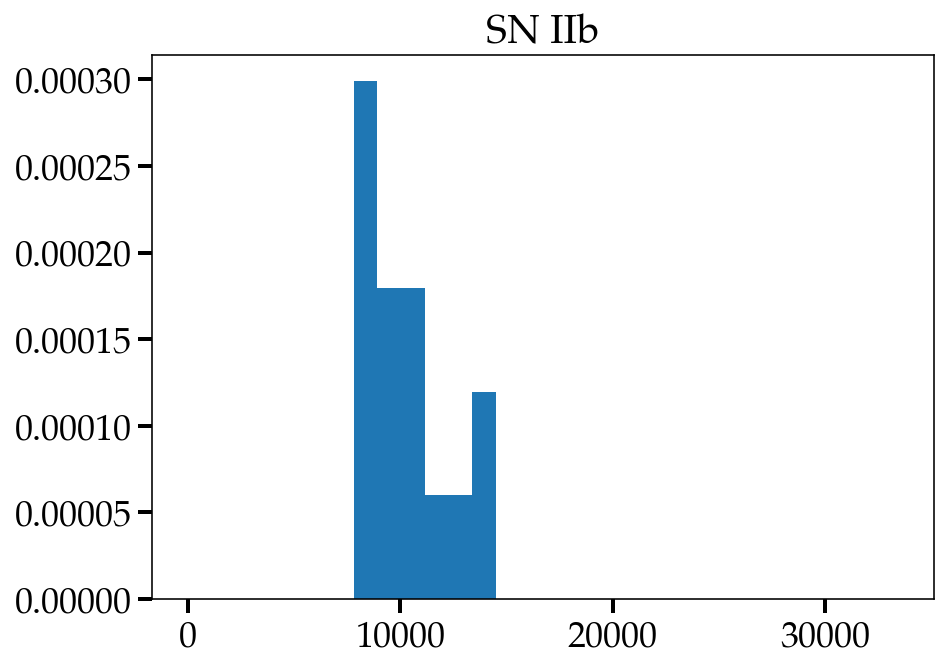

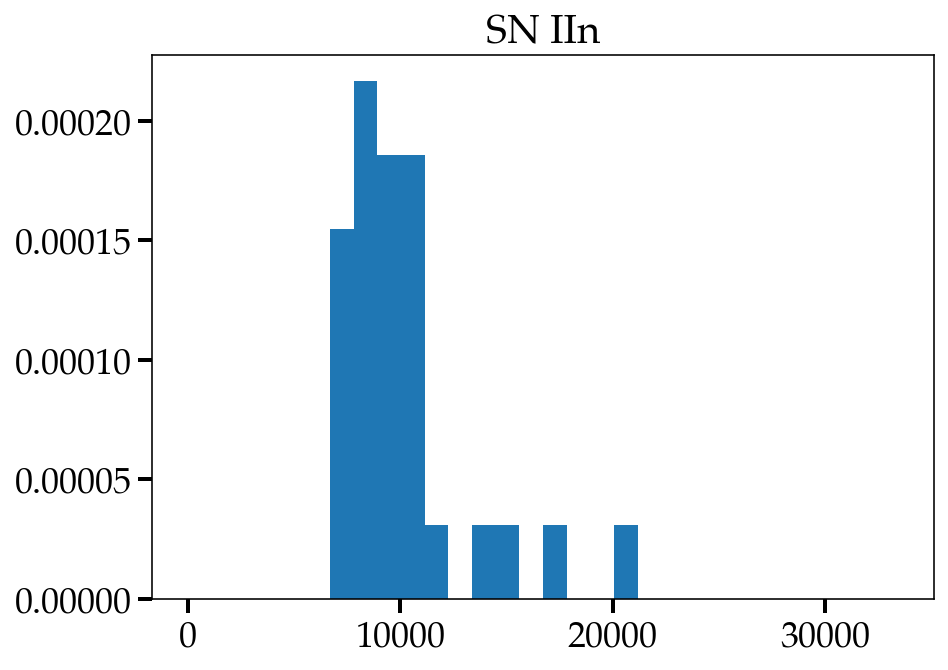

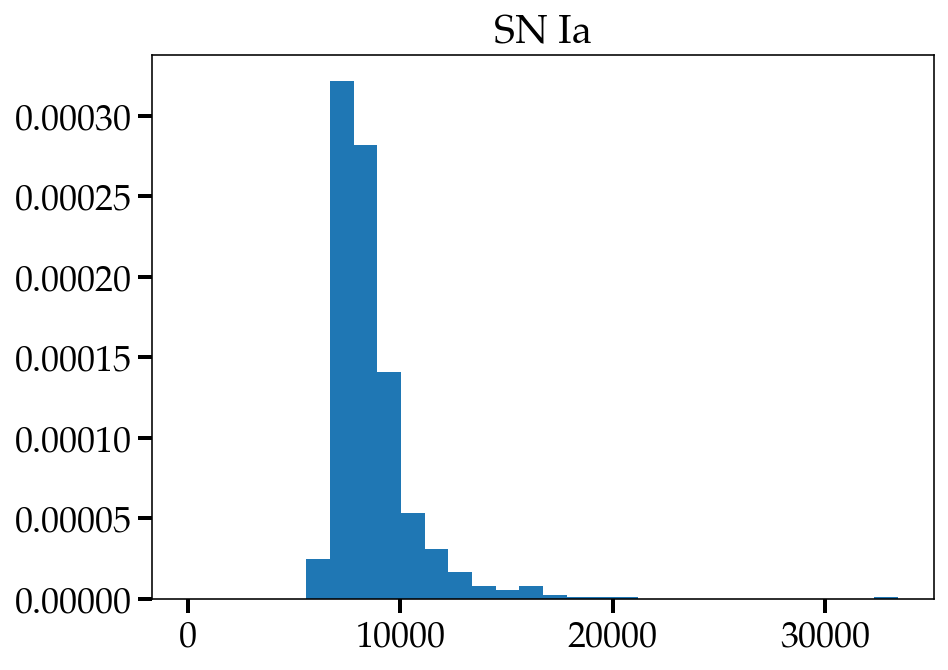

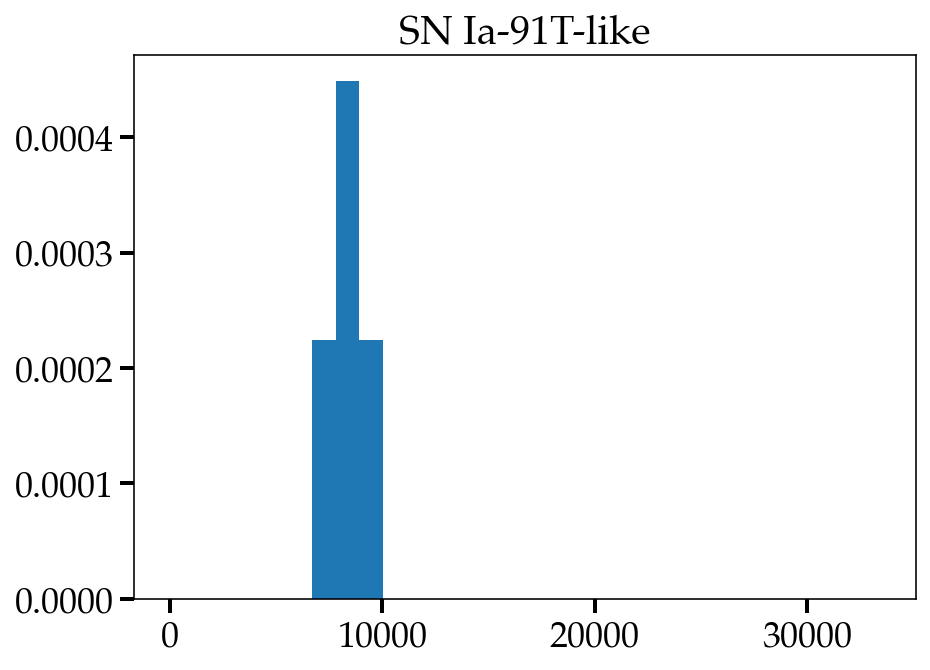

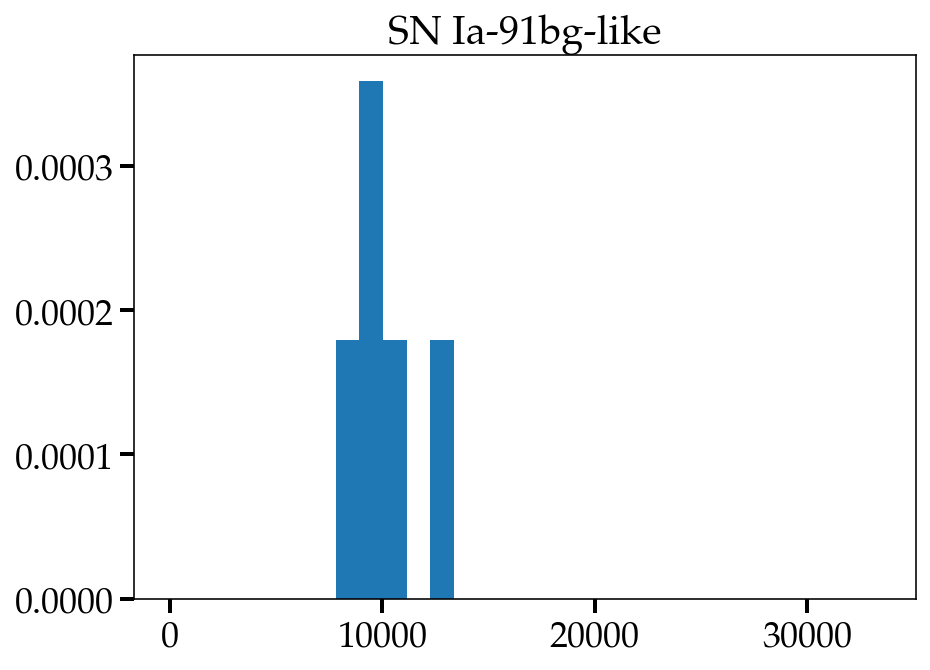

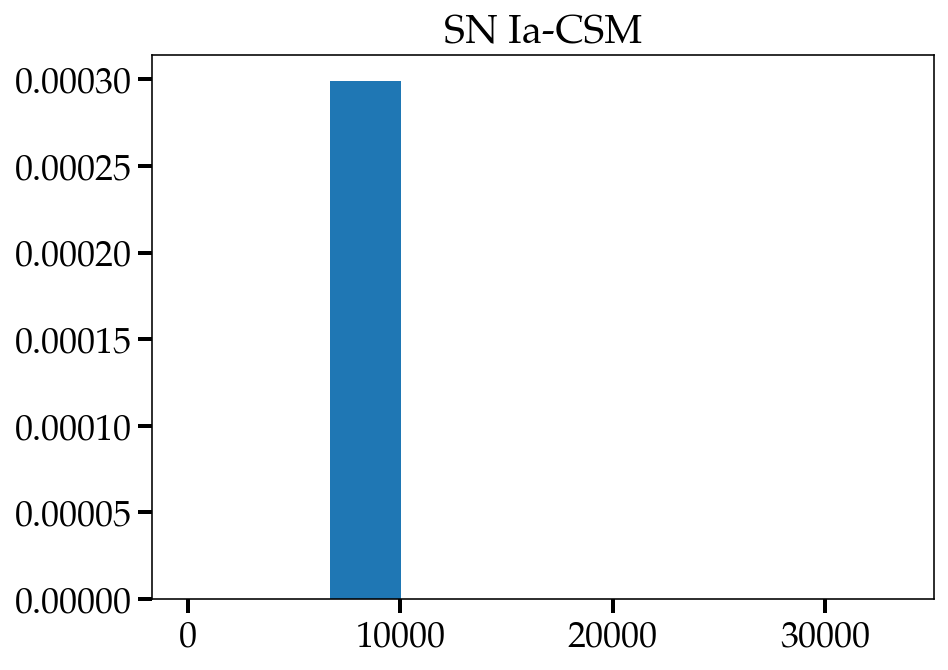

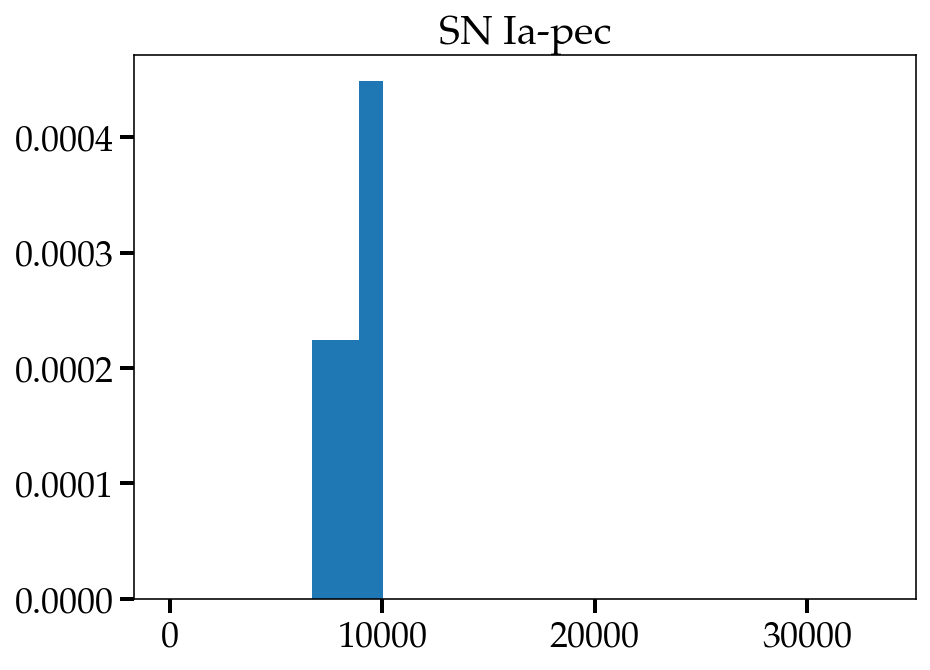

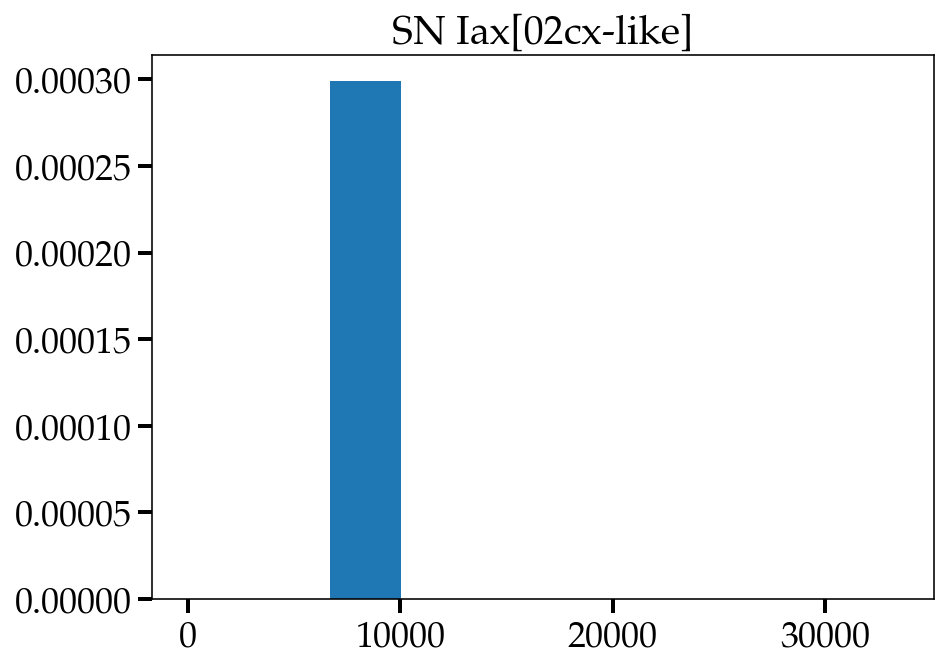

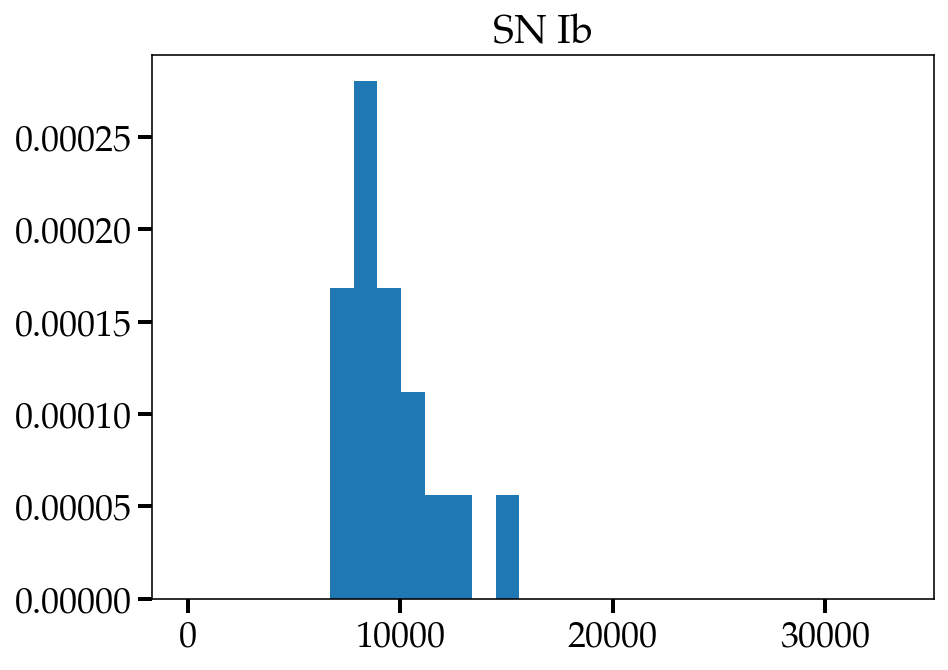

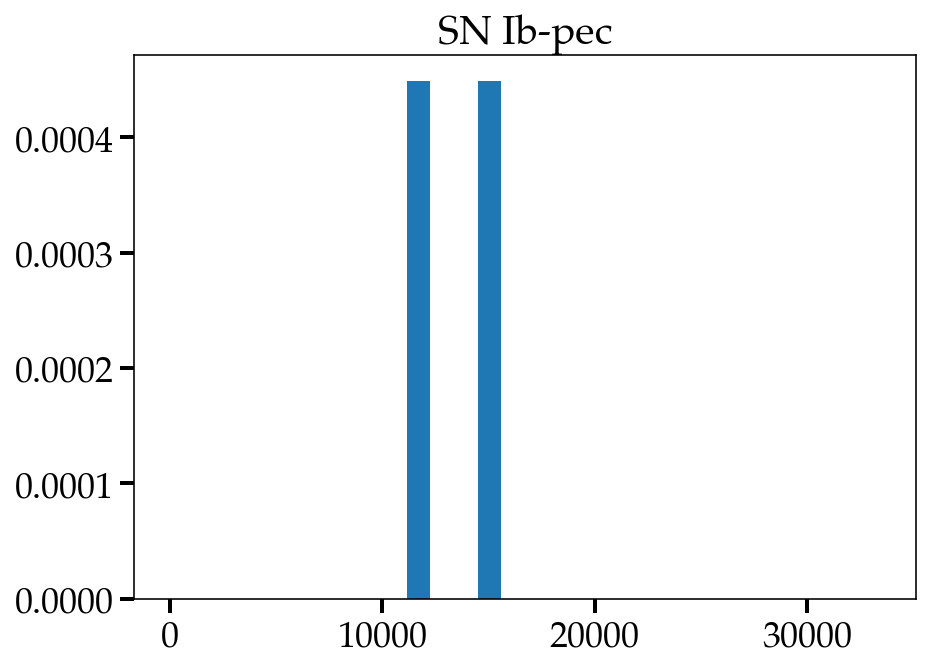

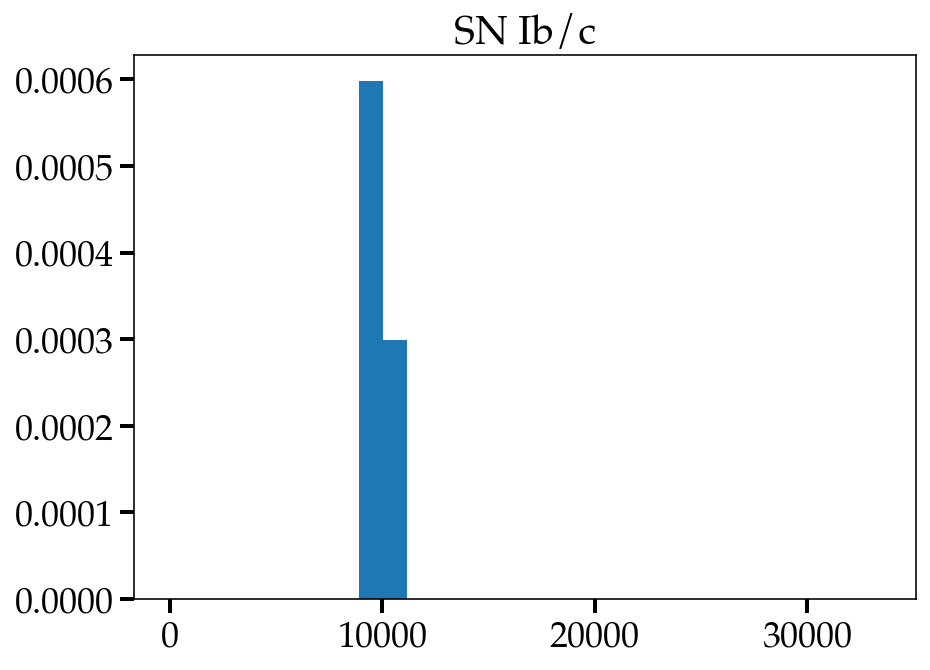

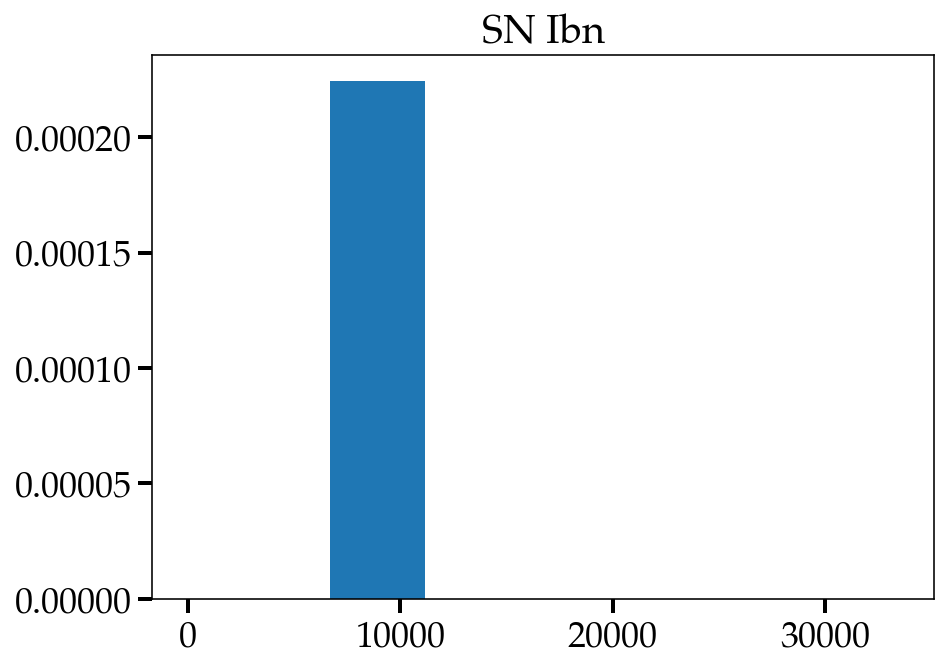

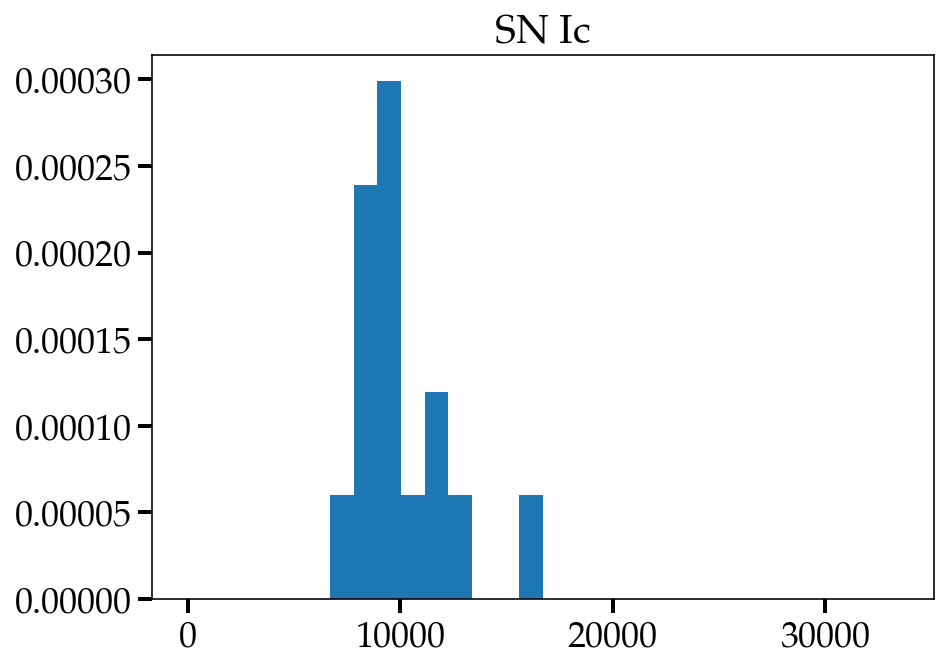

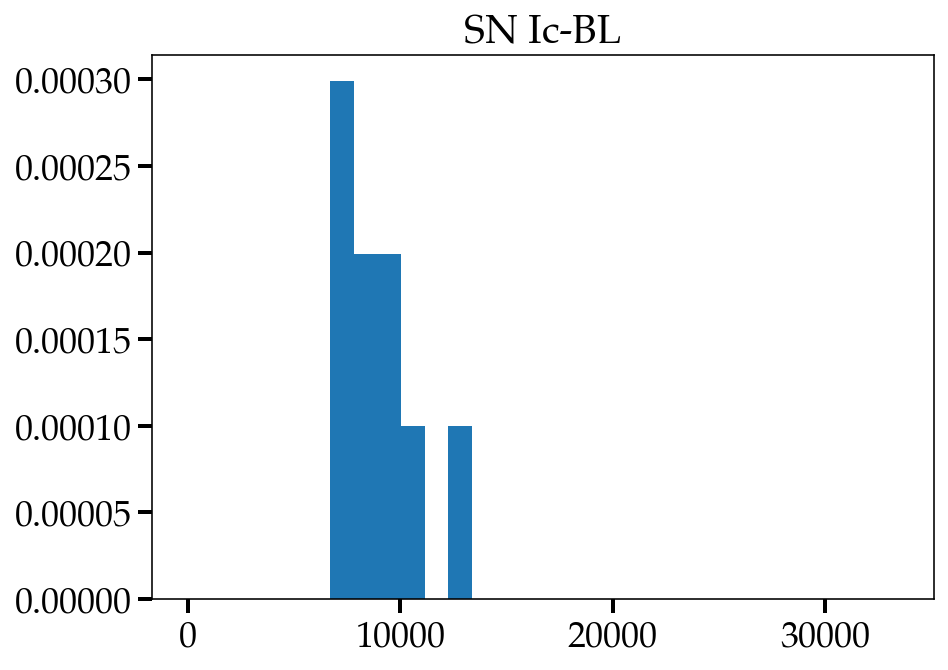

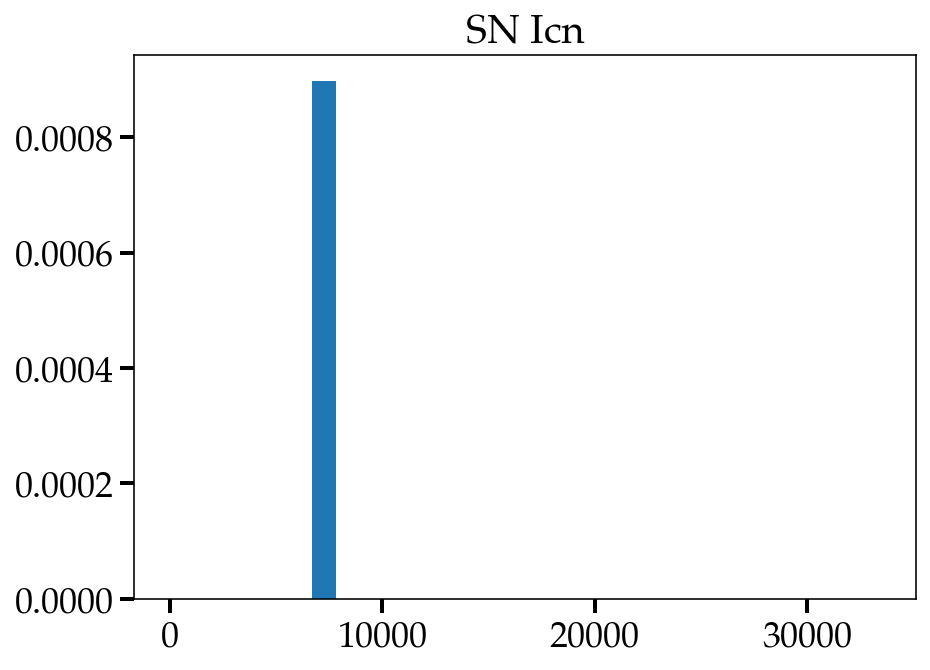

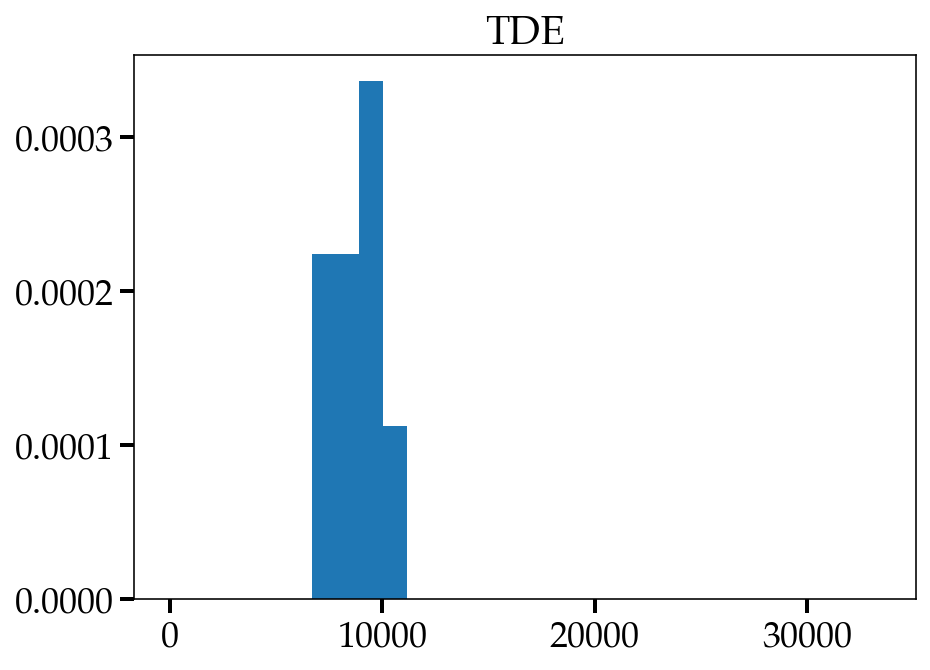

In [61]:
for cls in np.unique(merge_df.tns_cls):
    fig, ax = plt.subplots()
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, np.max(merge_df["WeightedMean-9ANNs"]), 31), density=True)
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(0, np.max(merge_df[dist_col]), 31), density=True)
    
    ax.set_title(cls)
    #ax.set_xlim(0, 150)

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


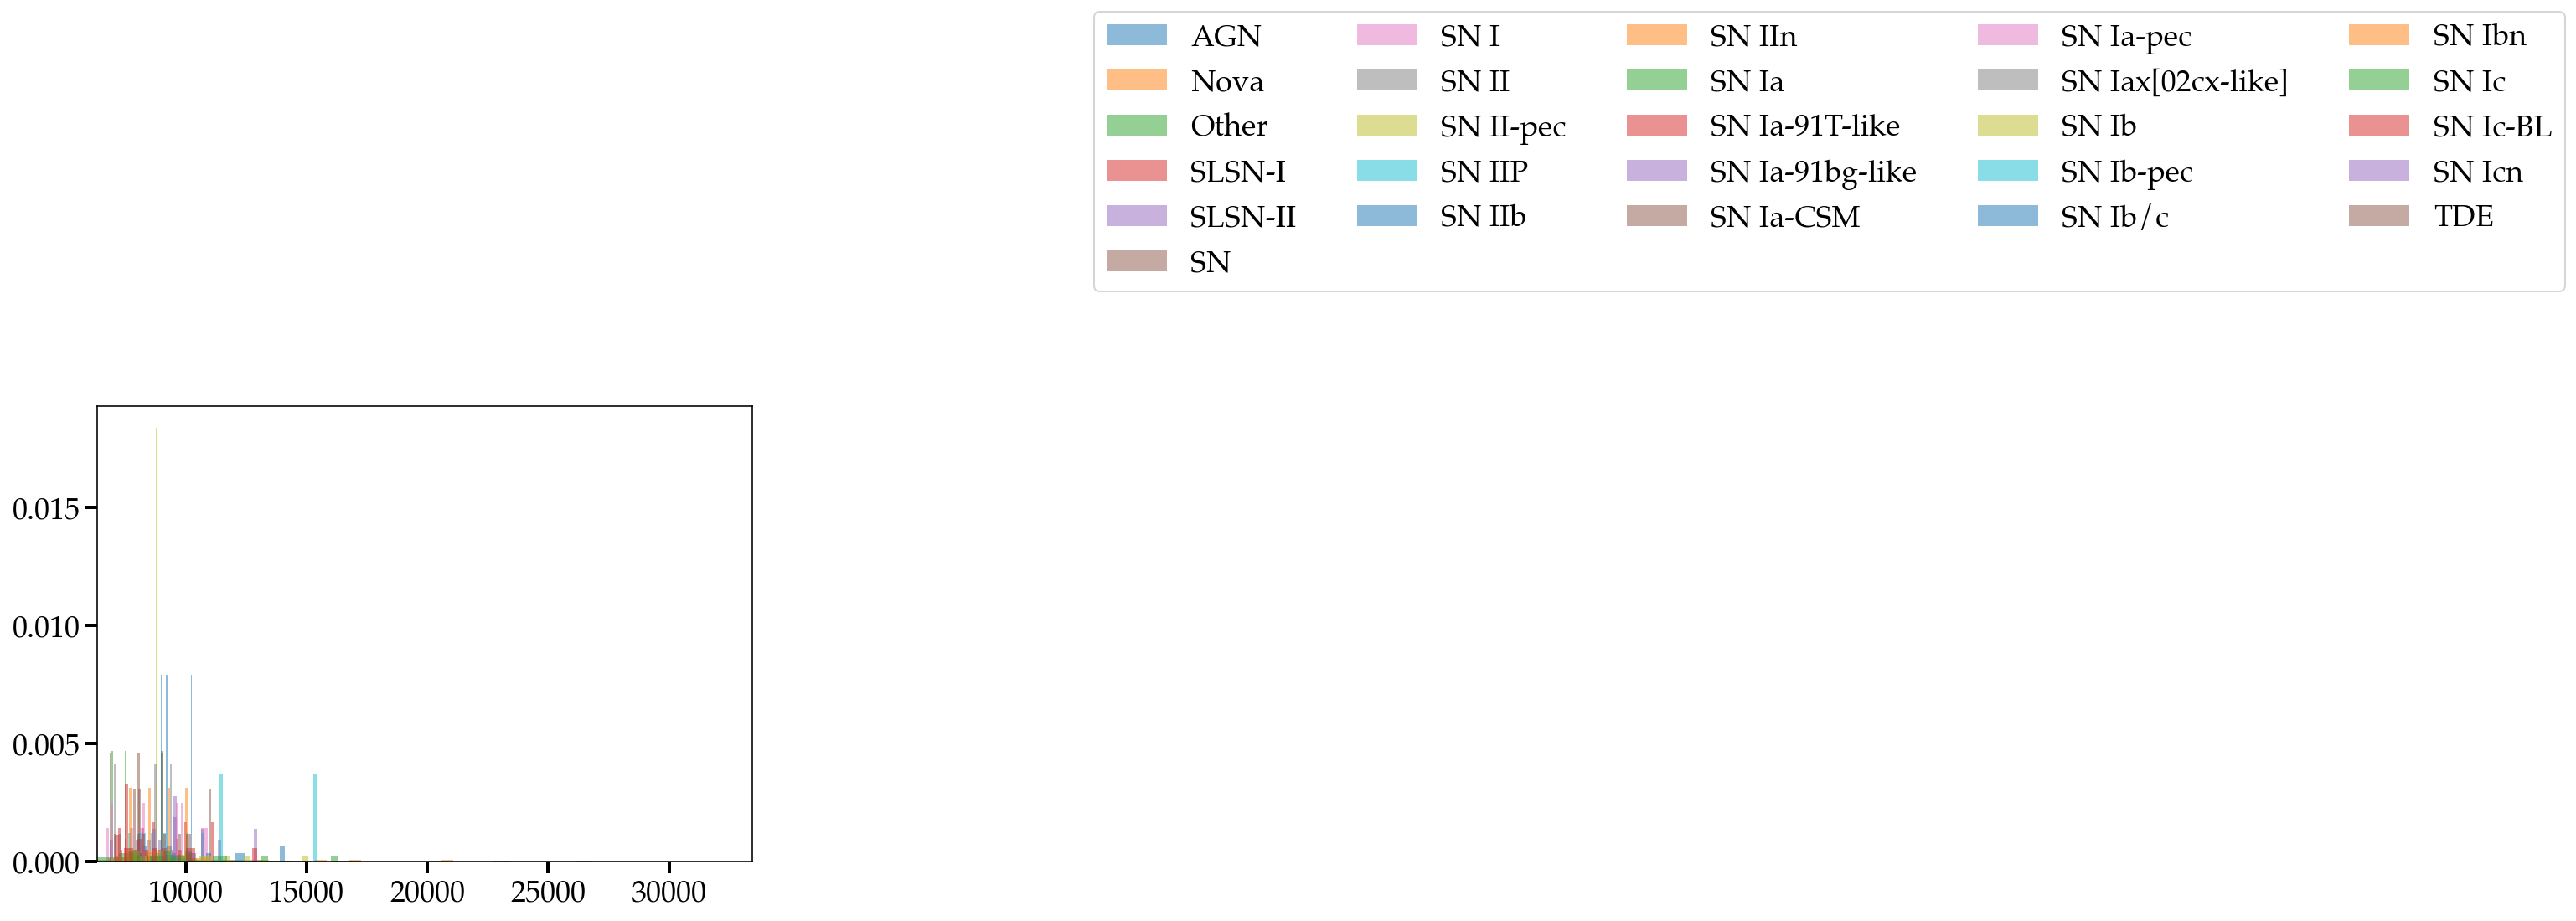

In [62]:
fig, ax = plt.subplots()

for cls in np.unique(merge_df.tns_cls):
    
    merge_df_cls = merge_df[merge_df.tns_cls == cls]
    
    #ax.hist(merge_df_cls["WeightedMean-9ANNs"], bins=np.linspace(0, 150, 31), 
    #        density=True, alpha=0.5, label=cls)
    
    ax.hist(merge_df_cls[dist_col], bins=np.linspace(np.min(merge_df_cls[dist_col]), np.max(merge_df_cls[dist_col]), 31), 
            density=True, alpha=0.5, label=cls)
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.legend(ncol=5, bbox_to_anchor=(1.5,1.9))

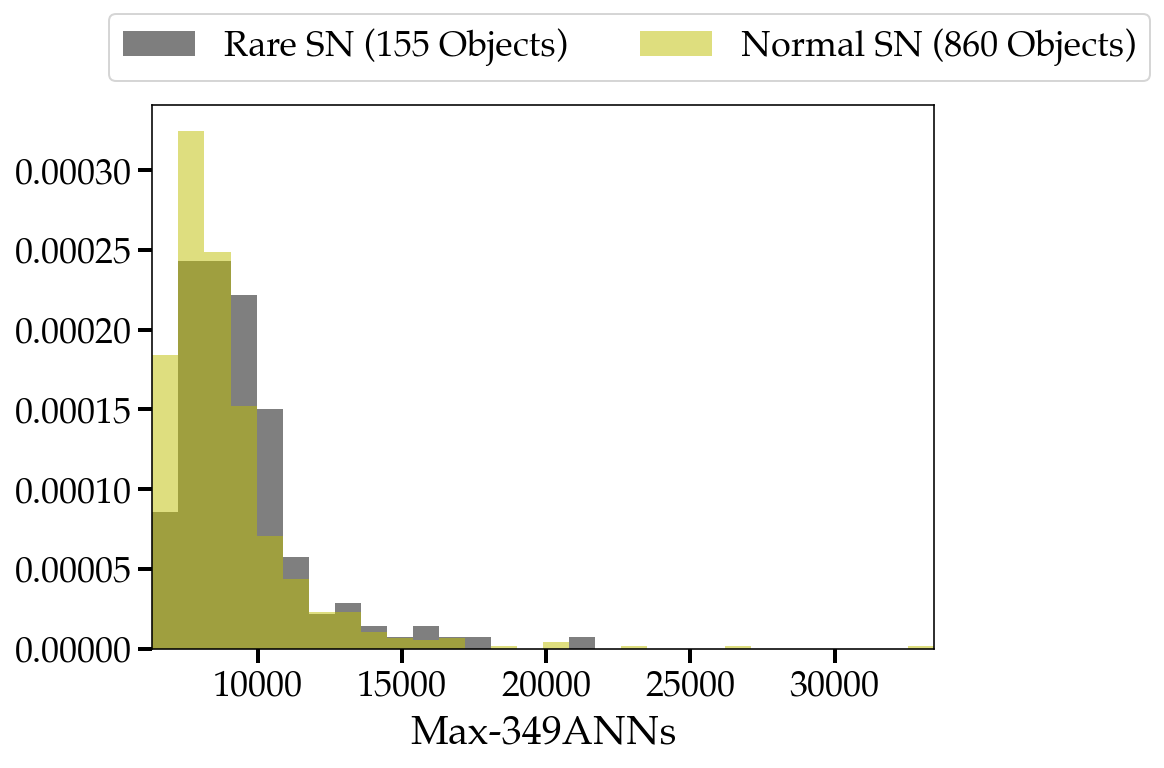

In [63]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
#plt.xscale('log')
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}.png')
plt.show()

In [64]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test

# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df[dist_col], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df[dist_col], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.21935483870967742
P-value: 0.010958893386391822
The two distributions are likely different.


In [65]:
np.median(normal_sn_df[dist_col])

8259.9697265625

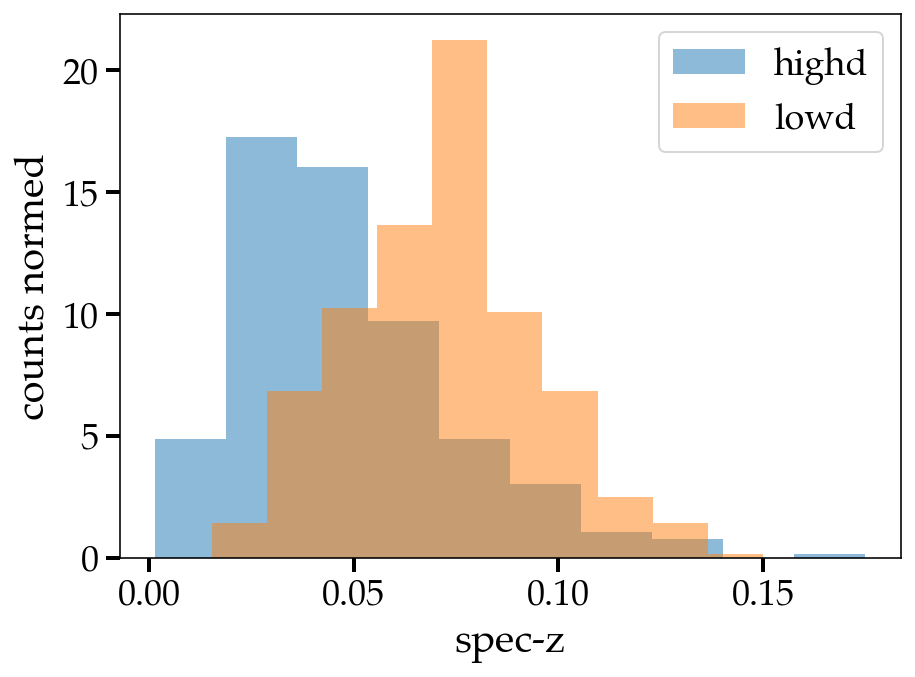

In [66]:
normal_sn_highd_df = normal_sn_df[normal_sn_df[dist_col] >= 8500]
normal_sn_lowd_df = normal_sn_df[normal_sn_df[dist_col] <= 8500]

plt.hist(normal_sn_highd_df.spec_z, alpha=0.5, density=True, label='highd')
plt.hist(normal_sn_lowd_df.spec_z, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [67]:
len(normal_sn_highd_df)

381

In [68]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_lowd_df.spec_z, size=len(normal_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.46981627296587924
P-value: 9.08111385837674e-33
The two distributions are likely different.


In [69]:
np.median(rare_sn_df[dist_col])

8970.84765625

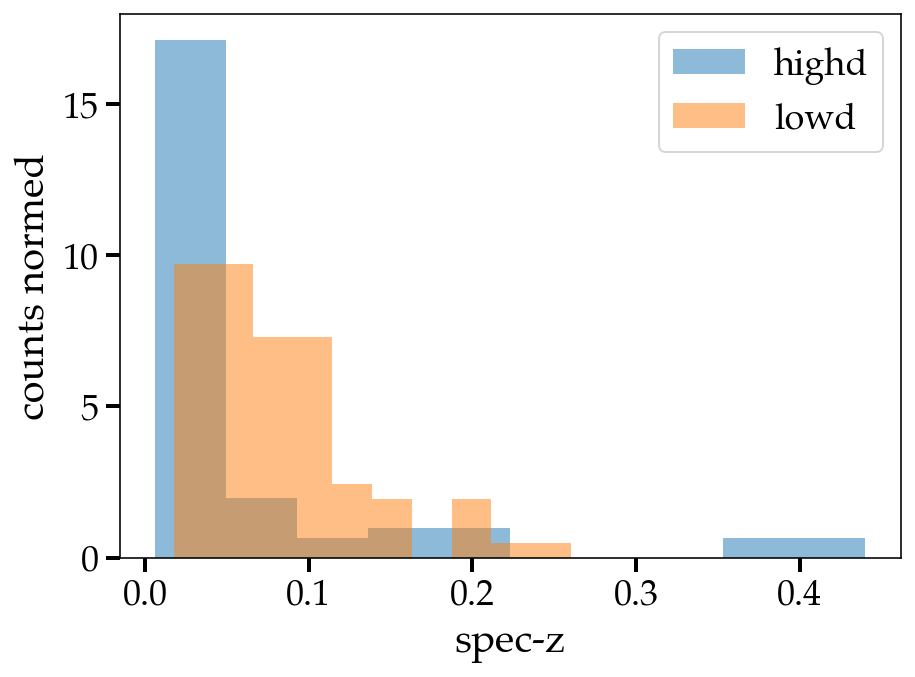

In [70]:
rare_sn_highd_df = rare_sn_df[rare_sn_df[dist_col] >= 9200]
rare_sn_lowd_df = rare_sn_df[rare_sn_df[dist_col] <= 9200]

plt.hist(rare_sn_highd_df.spec_z, alpha=0.5, density=True, label='highd')
plt.hist(rare_sn_lowd_df.spec_z, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [71]:
len(rare_sn_lowd_df)

85

In [72]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_sn_lowd_df.spec_z, size=len(rare_sn_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.44285714285714284
P-value: 2.255919680311712e-06
The two distributions are likely different.


fig, ax = plt.subplots()
bins=np.linspace(25, 150, 31)
    

rare_sn_l = ['SLSN-I', 'SLSN-II', 'SN II-pec', 'SN IIb', 'SN IIn', 'SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM',
   'SN Ia-pec', 'SN Iax[02cx-like]', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
   'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Icn', 'TDE']
rare_sn_df = merge_df[merge_df.tns_cls.isin(rare_sn_l)]
ax.hist(rare_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN ({len(rare_sn_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_sn_l = ['SN', 'SN I', 'SN II', 'SN Ia']
normal_sn_df = merge_df[merge_df.tns_cls.isin(normal_sn_l)]
ax.hist(normal_sn_df["Mean-49ANNs"], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN ({len(normal_sn_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(25, 150)
plt.xlabel('Mean-49ANNs')
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig('../figures/histograms/ann_dist_all_df_hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_2cls_Mean.png')
plt.show()

from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_sn_df["Mean-49ANNs"], size=len(rare_sn_df), replace=False)
    stat, p_value = ks_2samp(rare_sn_df["Mean-49ANNs"], normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

## No statistical difference between Rare SN and Normal SN 

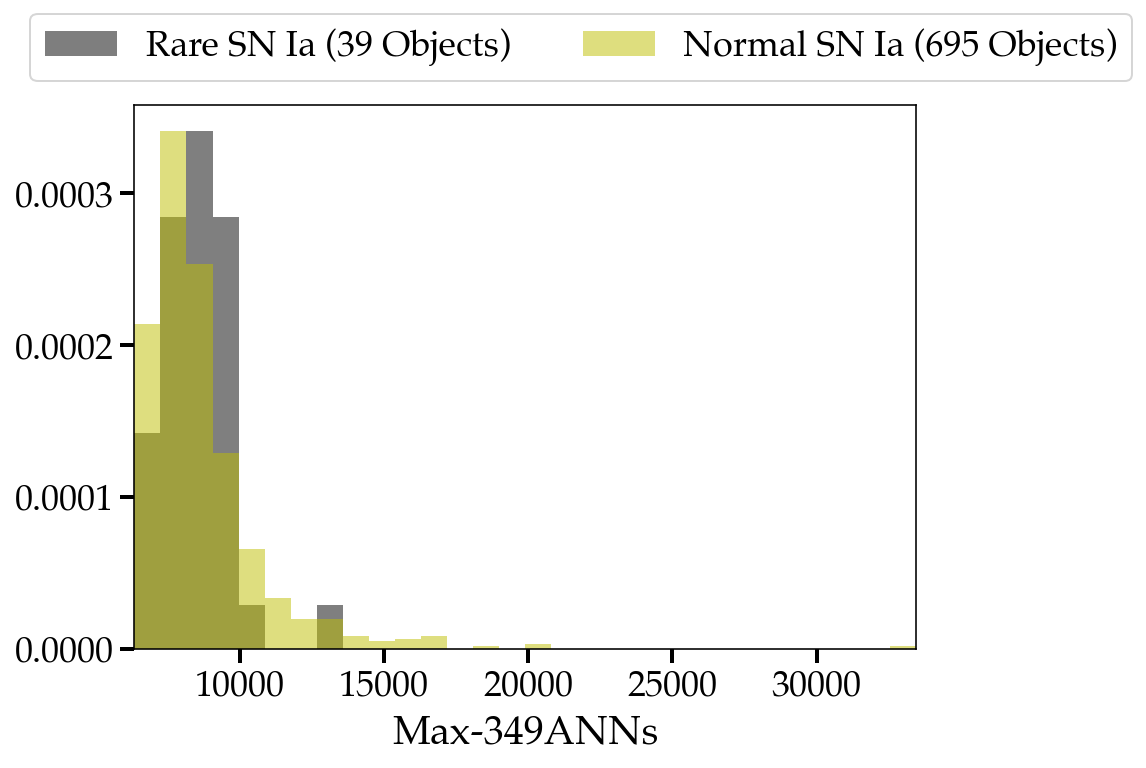

In [73]:
fig, ax = plt.subplots()
bins=np.linspace(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]), 31)
    

rare_snIa_l = ['SN Ia-91T-like', 'SN Ia-91bg-like', 'SN Ia-CSM', 'SN Ia-pec', 'SN Iax[02cx-like]']
rare_snIa_df = merge_df[merge_df.tns_cls.isin(rare_snIa_l)]
ax.hist(rare_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="k", label=f"Rare SN Ia ({len(rare_snIa_df)} Objects)")

# none_l = ['None']
# none_df = merge_df[merge_df.tns_cls.isin(none_l)]
# ax.hist(none_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="m",label="None")

normal_snIa_l = ['SN Ia']
normal_snIa_df = merge_df[merge_df.tns_cls.isin(normal_snIa_l)]
ax.hist(normal_snIa_df[dist_col], bins=bins, 
        density=True, alpha=0.5, color="y", label=f"Normal SN Ia ({len(normal_snIa_df)} Objects)")

# not_sn_l = ['AGN', 'CV', 'Nova']
# not_sn_df = merge_df[merge_df.tns_cls.isin(not_sn_l)]
# ax.hist(not_sn_df["WeightedMean-9ANNs"], bins=bins, 
#         density=True, alpha=0.5, color="c", label="Not SN")
    
plt.xlim(np.min(merge_df[dist_col]), np.max(merge_df[dist_col]))
plt.xlabel(dist_col)
plt.legend(ncol=4, bbox_to_anchor=(1.3,1.2));
plt.savefig(f'../figures/histograms/ann_dist_all_df_{suffix}_2cls_{dist_col}_Ia.png')
plt.show()

In [74]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_snIa_subsample = np.random.choice(normal_snIa_df[dist_col], size=len(rare_snIa_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_df[dist_col], normal_snIa_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.15384615384615385
P-value: 0.4262646556261012
The two distributions are likely the same.


## No statistical difference between Rare SN Ia and Normal SN Ia...

In [75]:
np.median(normal_snIa_df[dist_col])

8153.7119140625

In [76]:
normal_snIa_highd_df = normal_snIa_df[normal_snIa_df[dist_col] >= 9000]
normal_snIa_lowd_df = normal_snIa_df[normal_snIa_df[dist_col] <= 9000]

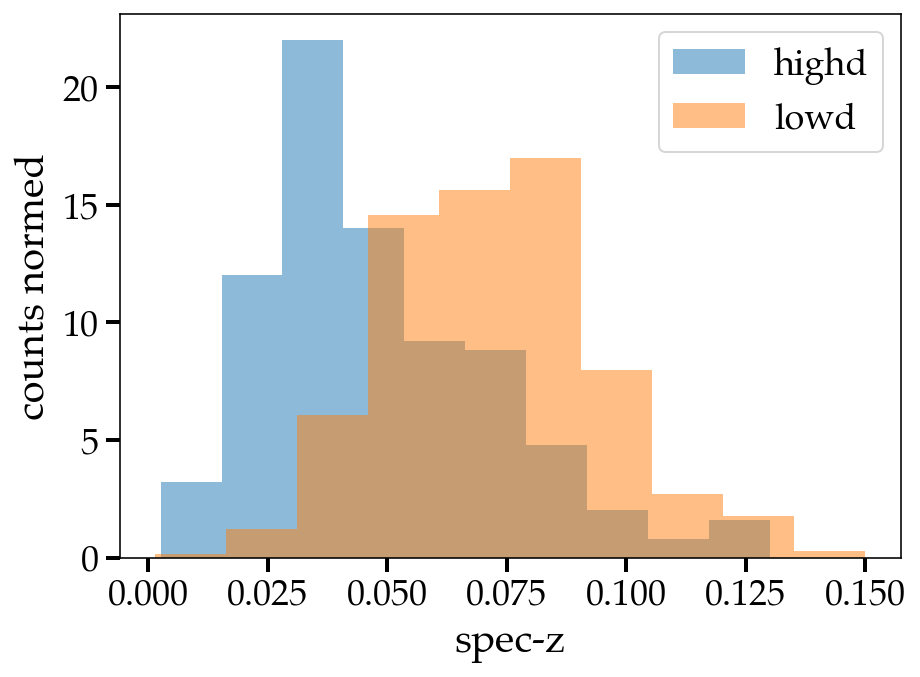

In [77]:
plt.hist(normal_snIa_highd_df.spec_z, alpha=0.5, density=True, label='highd')
plt.hist(normal_snIa_lowd_df.spec_z, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [78]:
normal_snIa_highd_df.spec_z

ztf_object_id
ZTF18aahfbqp    0.041362
ZTF18aansqom    0.030000
ZTF18aatgdph    0.035896
ZTF18aawfofp    0.033296
ZTF18abrbywo    0.043500
                  ...   
ZTF21abwqrwo    0.090000
ZTF21abxsngi    0.042000
ZTF21acenkuf    0.012319
ZTF21achauvx    0.041000
ZTF21ackhddc    0.064100
Name: spec_z, Length: 196, dtype: float64

In [79]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(normal_snIa_lowd_df.spec_z, size=len(normal_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(normal_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.4846938775510204
P-value: 1.942714100779448e-17
The two distributions are likely different.


In [80]:
np.median(rare_snIa_df[dist_col])

8254.2919921875

In [81]:

rare_snIa_highd_df = rare_snIa_df[rare_snIa_df[dist_col] >= 9000]
rare_snIa_lowd_df = rare_snIa_df[rare_snIa_df[dist_col] <= 9000]

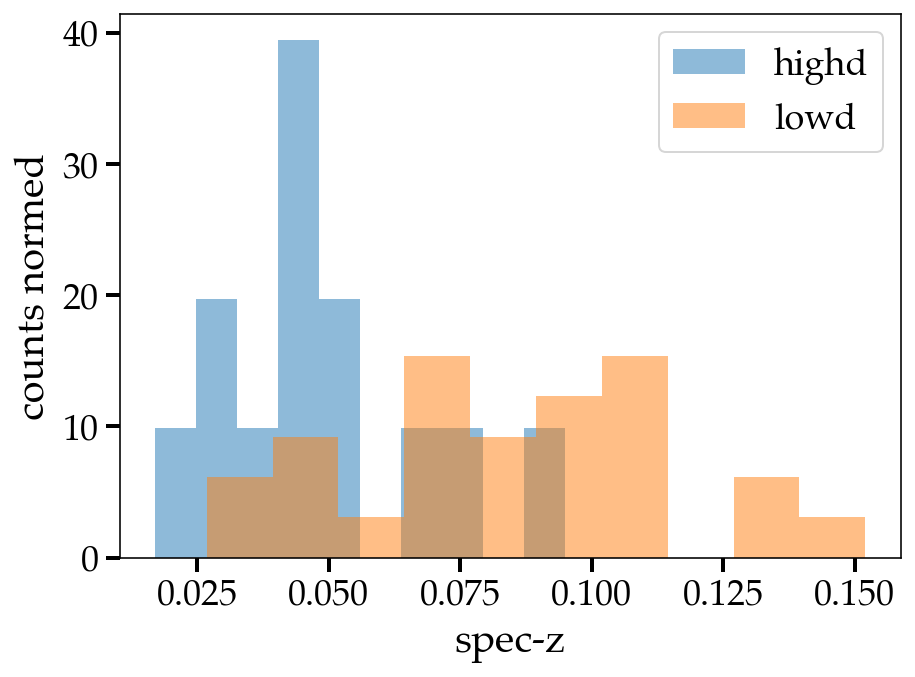

In [82]:
plt.hist(rare_snIa_highd_df.spec_z, alpha=0.5, density=True, label='highd')
plt.hist(rare_snIa_lowd_df.spec_z, alpha=0.5, density=True, label='lowd')
plt.xlabel('spec-z')
plt.ylabel('counts normed')
plt.legend()

In [83]:
len(rare_snIa_highd_df)

13

In [84]:
from scipy.stats import ks_2samp

# Perform the KS test
# Imbalanced datasets affect KS test, so subsample larger (normal SN sample) to match rare SN Sample 
# Or implement the Mann-Whitney U test
# run 100 tests
i=0
p_value_l = []
while i<1000:
    normal_sn_subsample = np.random.choice(rare_snIa_lowd_df.spec_z, size=len(rare_snIa_highd_df), replace=False)
    stat, p_value = ks_2samp(rare_snIa_highd_df.spec_z, normal_sn_subsample)
    i+=1
    p_value_l.append(p_value)

# Print the results
p_value = np.mean(p_value_l)
print(f"KS test statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The two distributions are likely the same.")
else:
    print("The two distributions are likely different.")

KS test statistic: 0.6923076923076923
P-value: 0.010223935157587061
The two distributions are likely different.


# Objs w/ high distances ANNs are Bright/closeby (generally...)
# TODO: how to define "rare"? --> Closeby & bright or rare phenomenology or ???
# Maybe "normalize out" brightness to focus on truly rare SN classes/types/ LCs?

# UPDATED: brightness CAN be normalized out, but tradeoff between good similarity (and host galaxy). If host gal weights all = 0.008 (1/120), then sim is good but high d and low d correspond to low z and high z, respectively. However, if I don't overweight hosts, sim search is not as good but high d and low d DO NOT correspond to low z and high z. So high d and low d objects are not dependent on redshift! But still no diff between rare SN and normal SN ... :( ?

In [85]:
# rare b/c closeby and bright or dust extincted or lc on decline

for snia in normal_snIa_highd_df.index:
    print(f'https://alerce.online/object/{snia}')

https://alerce.online/object/ZTF18aahfbqp
https://alerce.online/object/ZTF18aansqom
https://alerce.online/object/ZTF18aatgdph
https://alerce.online/object/ZTF18aawfofp
https://alerce.online/object/ZTF18abrbywo
https://alerce.online/object/ZTF18abxhsyn
https://alerce.online/object/ZTF18acbvgtu
https://alerce.online/object/ZTF18acbyyff
https://alerce.online/object/ZTF18accrorf
https://alerce.online/object/ZTF18acptgzz
https://alerce.online/object/ZTF18acsohut
https://alerce.online/object/ZTF18acsremz
https://alerce.online/object/ZTF18actuhrs
https://alerce.online/object/ZTF18acuimze
https://alerce.online/object/ZTF19aamdmcs
https://alerce.online/object/ZTF20aatxryt
https://alerce.online/object/ZTF20abeywdn
https://alerce.online/object/ZTF20abnbilr
https://alerce.online/object/ZTF20abptxls
https://alerce.online/object/ZTF20abqaqgv
https://alerce.online/object/ZTF20abqfgee
https://alerce.online/object/ZTF20abqvsik
https://alerce.online/object/ZTF20absvtnc
https://alerce.online/object/ZTF20

In [86]:
rare_snIa_df[rare_snIa_df[dist_col] >= 9000]

,Mean-349ANNs,Max-349ANNs,has_tns,tns_cls,spec_z,report_group
ztf_object_id,,,,,,
ZTF18aafzers,8360.640333,9913.776367,Yes_TNS,SN Ia-pec,0.048708,ALeRCE
ZTF20abmlxrx,8021.026899,9032.792969,Yes_TNS,SN Ia-CSM,0.095000,ATLAS
ZTF20abwrcmq,8246.075569,9432.330078,Yes_TNS,SN Iax[02cx-like],0.017000,ZTF
ZTF20acgkuay,7571.931000,9564.392578,Yes_TNS,SN Ia-91bg-like,0.048460,SGLF
ZTF20achuvhd,8563.639240,9608.884766,Yes_TNS,SN Ia-91T-like,0.076000,ALeRCE
ZTF20aczgoml,8026.285037,9452.515625,Yes_TNS,SN Ia-91T-like,0.045319,ZTF
ZTF21aagxmfv,8571.797181,9621.023438,Yes_TNS,SN Ia-91T-like,0.066000,ATLAS
ZTF21aamucom,8384.900220,9681.679688,Yes_TNS,SN Ia-91T-like,0.025000,ALeRCE
ZTF21aapjmda,7892.586284,9588.041992,Yes_TNS,SN Ia-91bg-like,0.026949,ATLAS


## TODO: find a new method for really Rare SN!
## TODO: Also, find if Rare SN--> Rare SN and Normal SN --> Normal SN

In [87]:
#suffix="noTNScut_NOpca_noCadence_NOtransf_HasHostGalOnly_SS_AlerceCls_fw_after"
#suffix="hasTNS-spec_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"
#suffix="hasTNS_NOpca_noCadence_NOtransf_HasHostGalOnly_SS"

full_ann_properties_df = pd.read_csv(f'../dataframes/full_ann_properties_df_{suffix}.csv', index_col=0)
full_ann_properties_df

,ann=0_ztfid,ann=1_ztfid,ann=2_ztfid,ann=3_ztfid,ann=4_ztfid,ann=5_ztfid,ann=6_ztfid,ann=7_ztfid,ann=8_ztfid,ann=9_ztfid,...,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z
0,ZTF18aabeszt,ZTF21aabvqlo,ZTF21aanyfqu,ZTF21aagyvtq,ZTF21aaoqbbw,ZTF21aaxtrlt,ZTF20acpkled,ZTF21aajvukh,ZTF20actfeym,ZTF21aaydwzt,...,0.081000,0.080178,0.067158,0.105047,0.050162,0.080000,0.091000,0.055000,0.055905,NaN
1,ZTF18aacnlxz,ZTF21aaxswlc,ZTF21aagnwkk,ZTF21abowqqa,ZTF20ackdkva,ZTF21aaxkckg,ZTF20aclkyjg,ZTF21aanefkx,ZTF21aaxxmvs,ZTF20accodxy,...,0.072475,0.072000,0.113000,0.090000,0.110000,0.063000,0.126000,0.260000,0.053000,0.075000
2,ZTF18aadlaxo,ZTF21abkkuja,ZTF21abasxdp,ZTF21aawtazf,ZTF21aantxma,ZTF20acywefl,ZTF20acoqpbg,ZTF20acuzfpk,ZTF20acpgzif,ZTF18aansqov,...,0.052953,0.054164,0.070000,0.061948,0.070230,0.058596,0.060170,0.057000,0.068770,0.070000
3,ZTF18aadsuxd,ZTF20acjhhqx,ZTF20aczacag,ZTF21aamfcji,ZTF21abowpnd,ZTF20abylbuf,ZTF20acxbbaj,ZTF21abhtaiv,ZTF20acwxbyr,ZTF21aatklhw,...,0.030570,0.040000,0.041065,0.046105,0.061306,0.046800,0.060000,0.081000,0.086093,0.066890
4,ZTF18aafzers,ZTF21abkaoxe,ZTF21aaheulr,ZTF21aagtceu,ZTF20acsesce,ZTF21abklcjq,ZTF21aabfwwl,ZTF20acpgnsn,ZTF21aagmoqw,ZTF21aanrhag,...,0.048708,0.054300,0.034000,0.044665,0.052000,0.025080,0.013639,0.036258,0.055400,0.039724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,ZTF21acipbwd,ZTF20acrhrcy,ZTF21aarojxa,ZTF21aaaouyd,ZTF21aapduck,ZTF20acoqlav,ZTF21aaqyifh,ZTF20acvbrbv,ZTF20acwqndp,ZTF20acuzfpk,...,0.094000,0.100000,0.088724,0.061270,0.058000,0.090000,0.018500,0.050000,0.053130,0.057000
1027,ZTF21aciuhqw,ZTF21aaydbtk,ZTF20achzugy,ZTF20actpbck,ZTF18aadlaxo,ZTF19acwiqrc,ZTF20acpkjsn,ZTF21aafnabs,ZTF21aajmkrd,ZTF21aaazieb,...,0.045000,0.057679,0.048000,0.060000,0.052953,0.048000,0.056000,0.087762,0.049405,0.038385
1028,ZTF21ackbbfs,ZTF20achtpbn,ZTF20achdwmq,ZTF21accuexh,ZTF21aagxmcs,ZTF20acgynyw,ZTF21aasbjgq,ZTF21aaplnef,ZTF21abjtqyq,ZTF21aapjmgf,...,0.045000,0.100000,0.060000,0.072000,0.085000,0.070000,0.080000,0.075000,0.097000,0.054000
1029,ZTF21ackhddc,ZTF21aarasky,ZTF21aaqyifh,ZTF21aajfpwk,ZTF20acoredl,ZTF21aaigqir,ZTF21aaydbtk,ZTF21aafnabs,ZTF21aaqprjz,ZTF20acpcuwx,...,0.064100,0.021698,0.018500,0.079139,0.057960,0.071186,0.057679,0.087762,0.080000,0.050000


In [88]:
full_ann_tns_cls_df = full_ann_properties_df.iloc[:, 30:40]
full_ann_tns_cls_df

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls
0,SN Ia,SN Ia,SN Ia,SN Ia,SN IIn,SN Ia-91T-like,SN Ia,SN II,SN Ia,SN Ia
1,SN II,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SLSN-II,SN IIb,SN Ia
2,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia
3,SN II,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia
4,SN Ia-pec,SN Ia,SN Ia,SN Ia,SN Ia,SN Ic,SN II,SN Ia,SN Ia,SN IIb
...,...,...,...,...,...,...,...,...,...,...
1026,SN Ia,SN Ia,SN Ia,SN I,SN Ia,SN Ia,SN II-pec,SN Ia-91bg-like,SN Ia,SN Ia
1027,SN Ic-BL,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia
1028,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN II
1029,SN Ia,SN IIb,SN II-pec,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia


In [89]:
full_ann_spec_z_df = full_ann_properties_df.iloc[:, 40:50]
full_ann_spec_z_df

,ann=0_spec_z,ann=1_spec_z,ann=2_spec_z,ann=3_spec_z,ann=4_spec_z,ann=5_spec_z,ann=6_spec_z,ann=7_spec_z,ann=8_spec_z,ann=9_spec_z
0,0.081000,0.080178,0.067158,0.105047,0.050162,0.080000,0.091000,0.055000,0.055905,NaN
1,0.072475,0.072000,0.113000,0.090000,0.110000,0.063000,0.126000,0.260000,0.053000,0.075000
2,0.052953,0.054164,0.070000,0.061948,0.070230,0.058596,0.060170,0.057000,0.068770,0.070000
3,0.030570,0.040000,0.041065,0.046105,0.061306,0.046800,0.060000,0.081000,0.086093,0.066890
4,0.048708,0.054300,0.034000,0.044665,0.052000,0.025080,0.013639,0.036258,0.055400,0.039724
...,...,...,...,...,...,...,...,...,...,...
1026,0.094000,0.100000,0.088724,0.061270,0.058000,0.090000,0.018500,0.050000,0.053130,0.057000
1027,0.045000,0.057679,0.048000,0.060000,0.052953,0.048000,0.056000,0.087762,0.049405,0.038385
1028,0.045000,0.100000,0.060000,0.072000,0.085000,0.070000,0.080000,0.075000,0.097000,0.054000
1029,0.064100,0.021698,0.018500,0.079139,0.057960,0.071186,0.057679,0.087762,0.080000,0.050000


In [90]:
# Create Graph df
graph_df = pd.DataFrame()
graph_df['node'] = full_ann_tns_cls_df["ann=0_tns_cls"]

ann_tns_cls_col_list= [f'ann={col}_tns_cls' for col in range(1, 10)]
graph_df['neighbors'] = full_ann_tns_cls_df[ann_tns_cls_col_list].apply(list, axis=1)
graph_df

,node,neighbors
0,SN Ia,"[SN Ia, SN Ia, SN Ia, SN IIn, SN Ia-91T-like, ..."
1,SN II,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SLS..."
2,SN Ia,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN ..."
3,SN II,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN ..."
4,SN Ia-pec,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ic, SN II, SN ..."
...,...,...
1026,SN Ia,"[SN Ia, SN Ia, SN I, SN Ia, SN Ia, SN II-pec, ..."
1027,SN Ic-BL,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN ..."
1028,SN Ia,"[SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN Ia, SN ..."
1029,SN Ia,"[SN IIb, SN II-pec, SN Ia, SN Ia, SN Ia, SN Ia..."


In [91]:
full_ann_tns_cls_df[full_ann_tns_cls_df['ann=0_tns_cls'] == 'SN Ibn']

,ann=0_tns_cls,ann=1_tns_cls,ann=2_tns_cls,ann=3_tns_cls,ann=4_tns_cls,ann=5_tns_cls,ann=6_tns_cls,ann=7_tns_cls,ann=8_tns_cls,ann=9_tns_cls
577,SN Ibn,SLSN-II,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia
627,SN Ibn,SN Ia-91T-like,SN IIn,SN Ia,SN II,SN Ia,SN Ia,SN Ia-91T-like,SN Ia,SN Ia
675,SN Ibn,SN Ia,SN Ia-91T-like,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia,SN Ia
782,SN Ibn,SN Ia,SN II,SN Ib,SN Ia-91bg-like,SN Ia,SN II,SN IIb,SN II,SN II


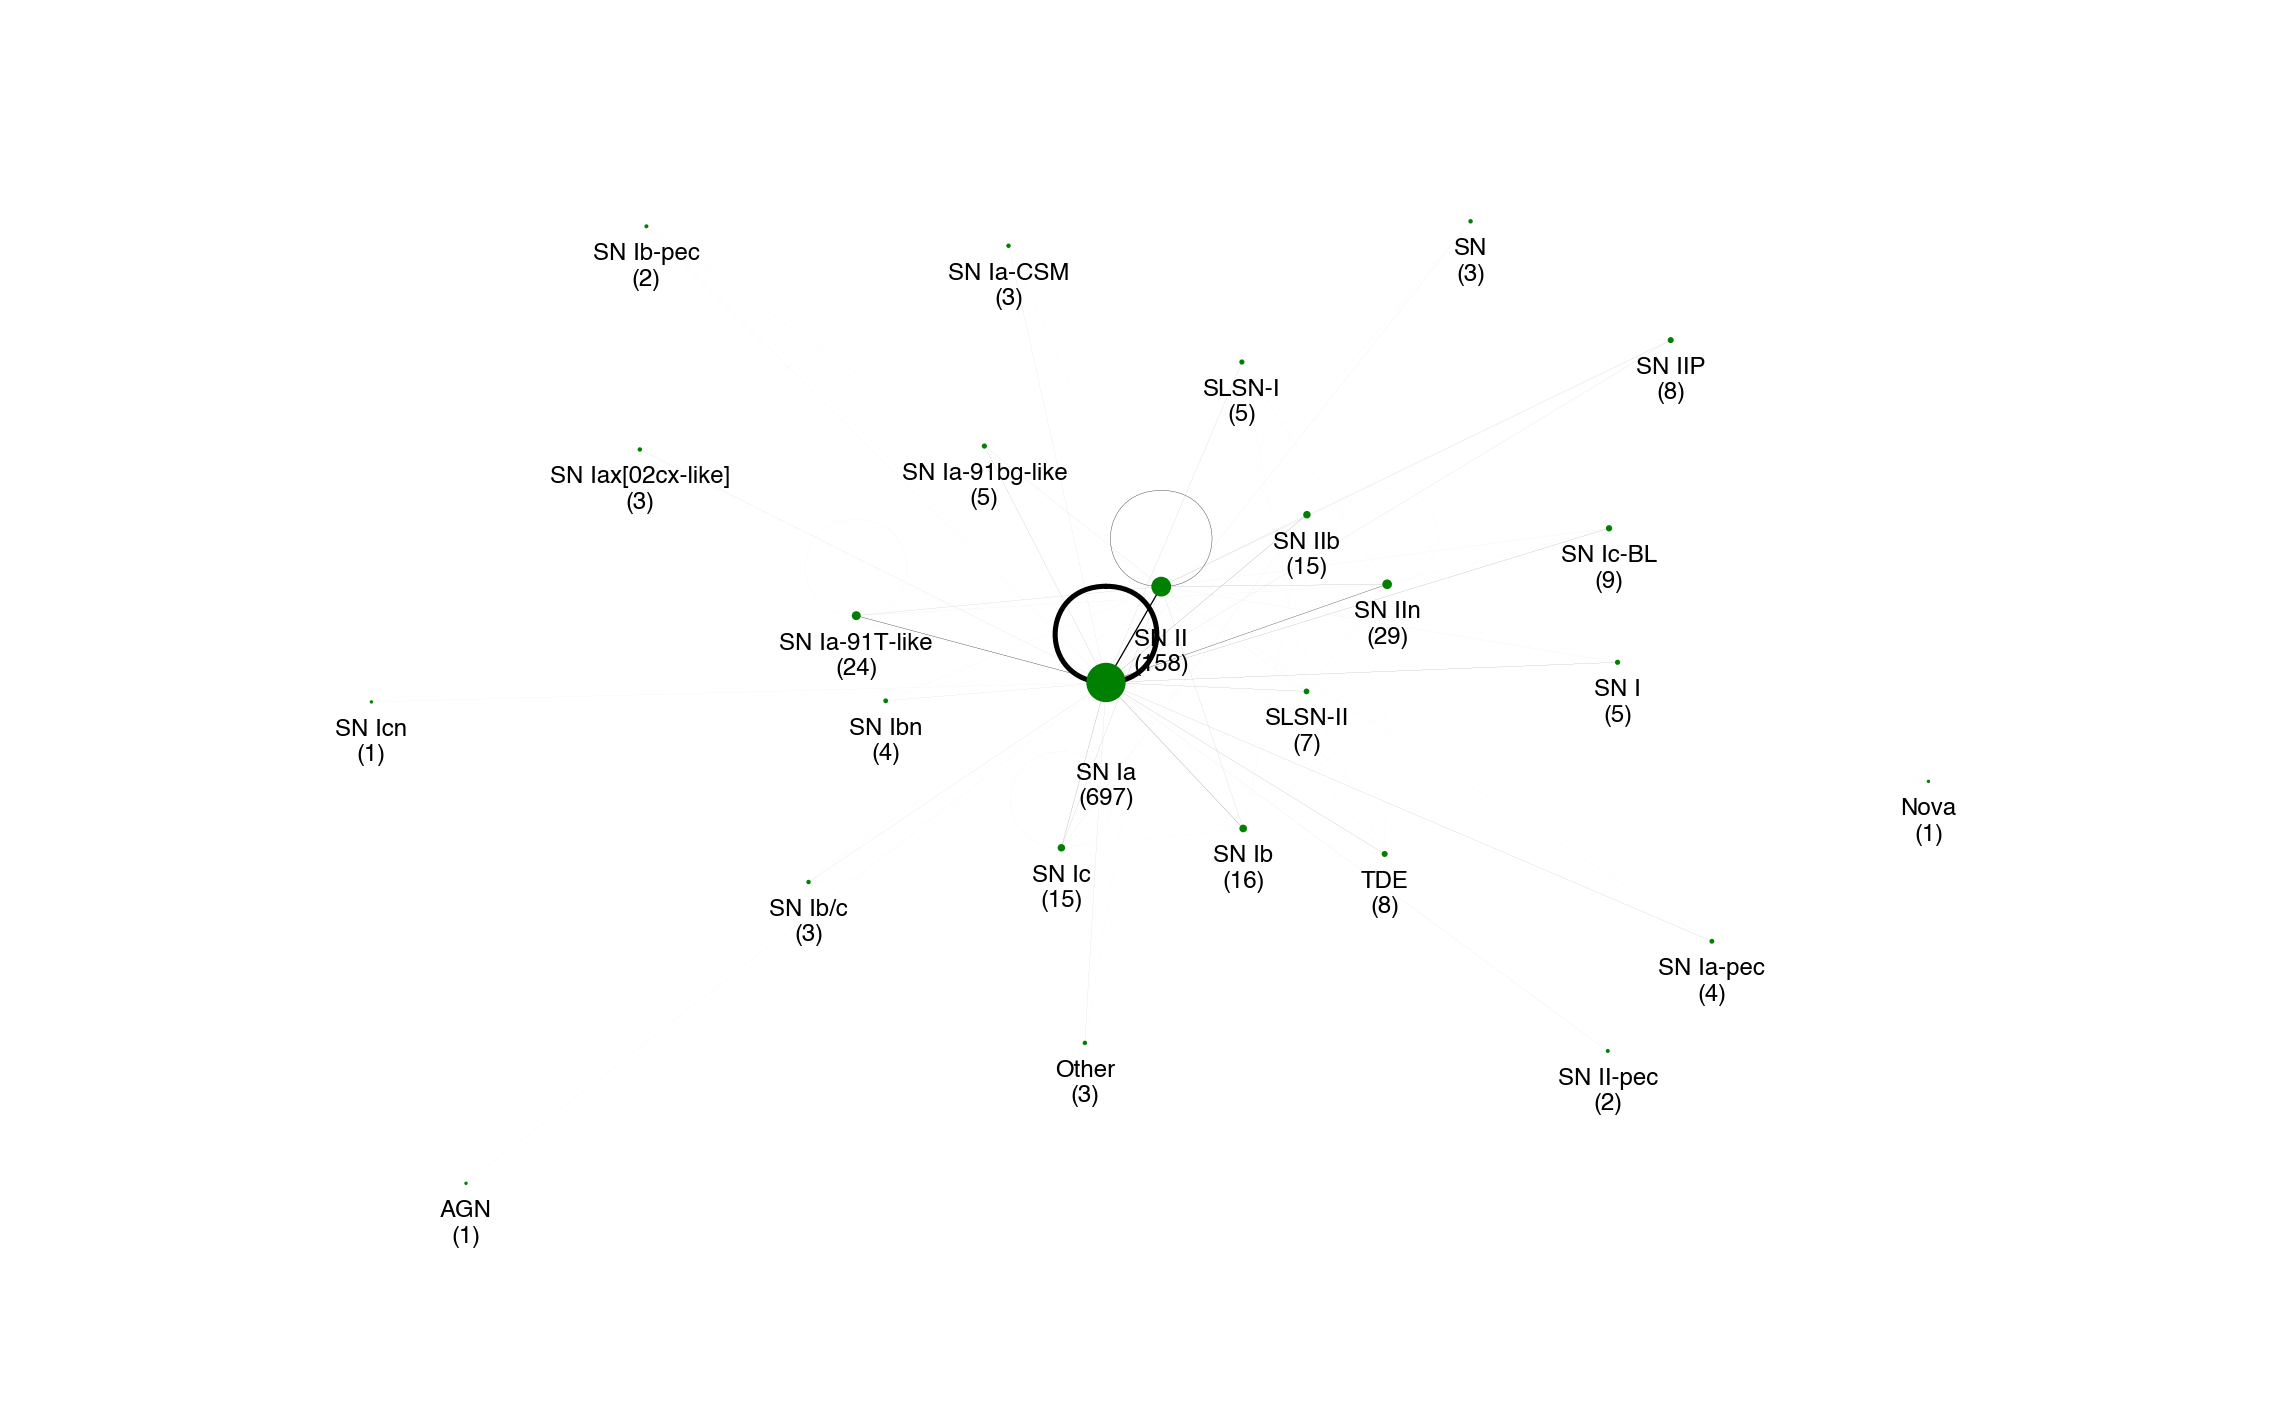

In [92]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Create a sample dataframe with node and edge data
df = graph_df.copy()
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.Graph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/2000 for edge in edge_labels]

node_count = dict(Counter(graph_df['node']))

# Scale the node sizes by the occurrences of the node
#node_sizes = [1.2 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        
node_sizes = [node_count[node] * 0.5 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(16, 10))
nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] - 0.07)
    
# count the number of times of each node 
node_count = dict(Counter(df['node']))

# scale node sizes by frequency
#node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels_d1 = {node: f"{node}\n({node_count[node]})" for node in G.nodes() if node!='SN Ia' and node!='SN II'}
node_labels_d2 = {node: f"\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN II'}
node_labels = {node: f"\n\n\n\n\n{node}\n({node_count[node]})" for node in G.nodes() if node=='SN Ia'}

node_labels_d2.update(node_labels_d1)
node_labels.update(node_labels_d2)

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
plt.savefig(f'../figures/graphs/{suffix}_size_scaled.jpg', dpi=300)
plt.show()


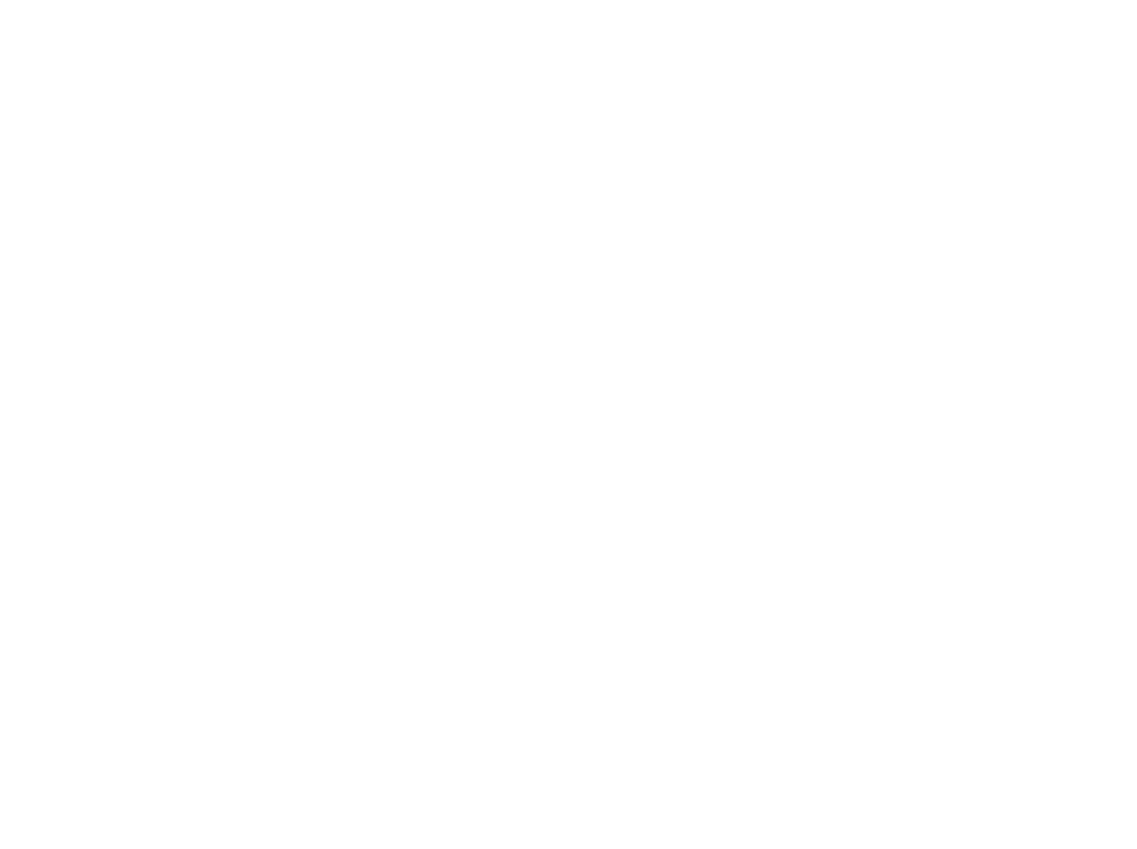

In [93]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

cls = 'None'
graph_df_cls = graph_df[graph_df.node == cls]


# Create a sample dataframe with node and edge data
df = graph_df_cls
# Create a list of edges
edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

# Create a network graph from the edges
G = nx.DiGraph()
G.add_edges_from(edges)

# Compute the frequency of each unique connection
edge_freq = {}
for u, v in edges:
    key = (min(u, v), max(u, v))
    edge_freq[key] = edge_freq.get(key, 0) + 1
    
# Add edge labels with frequency
edge_labels = {}
for u, v, d in G.edges(data=True):
    key = (min(u, v), max(u, v))
    #if edge_freq[key] >= 500:
    edge_labels[(u, v)] = str(edge_freq[key])
    
# set edge widths based on frequency
edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]

# Scale the node sizes by the occurrences of the node
#node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
#print(node_sizes)

# explode the lists in the second column into separate rows
df = graph_df_cls
df_expl = df.explode('neighbors')

# group the data frame by the label column and count the number of unique values for each group
unique_node_d = dict(Counter(df['node']))
unique_neighbors_d = dict(Counter(df_expl['neighbors']))

for key in unique_neighbors_d:
    if key in unique_node_d:
        unique_node_d[key] += unique_neighbors_d[key]
    else:
        unique_node_d[key] = unique_neighbors_d[key]
        
node_count = unique_node_d
node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
#print(node_sizes)

# Plot the graph
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

# Move the labels of the nodes down right below the node
pos_labels = {}
for key, value in pos.items():
    pos_labels[key] = (value[0], value[1] +.1)
    
    
# # count the number of times of each node 
# node_count = dict(Counter(graph_df_cv['node']))

# # scale node sizes by frequency
# node_sizes = [node_count[node] * 9 for node in G.nodes()]

# create labels with node and count information
node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')


plt.axis('off')
axis = plt.gca()
axis.set_xlim([1.2*x for x in axis.get_xlim()])
axis.set_ylim([1.2*y for y in axis.get_ylim()])
plt.tight_layout()
#plt.savefig(f'../figures/graphs/{suffix}_size_scaled_None.jpg', dpi=300)
plt.show()


AGN


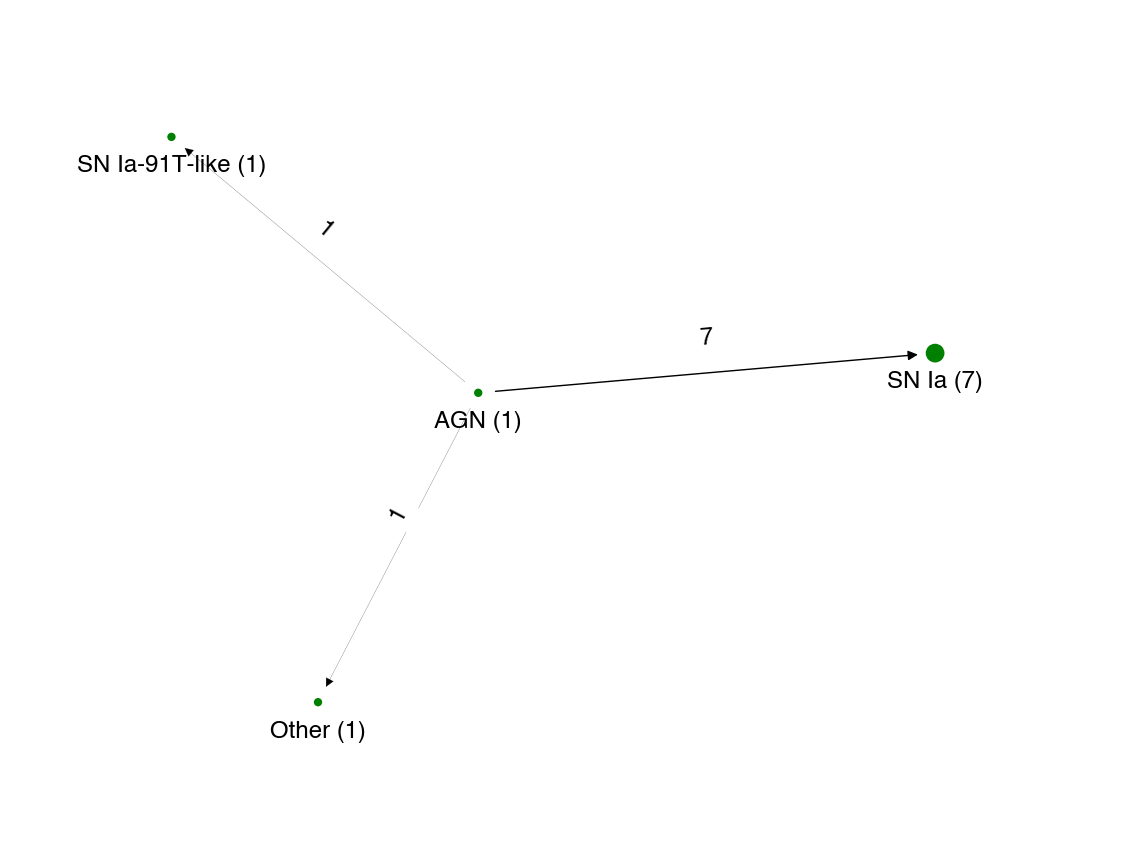

Nova


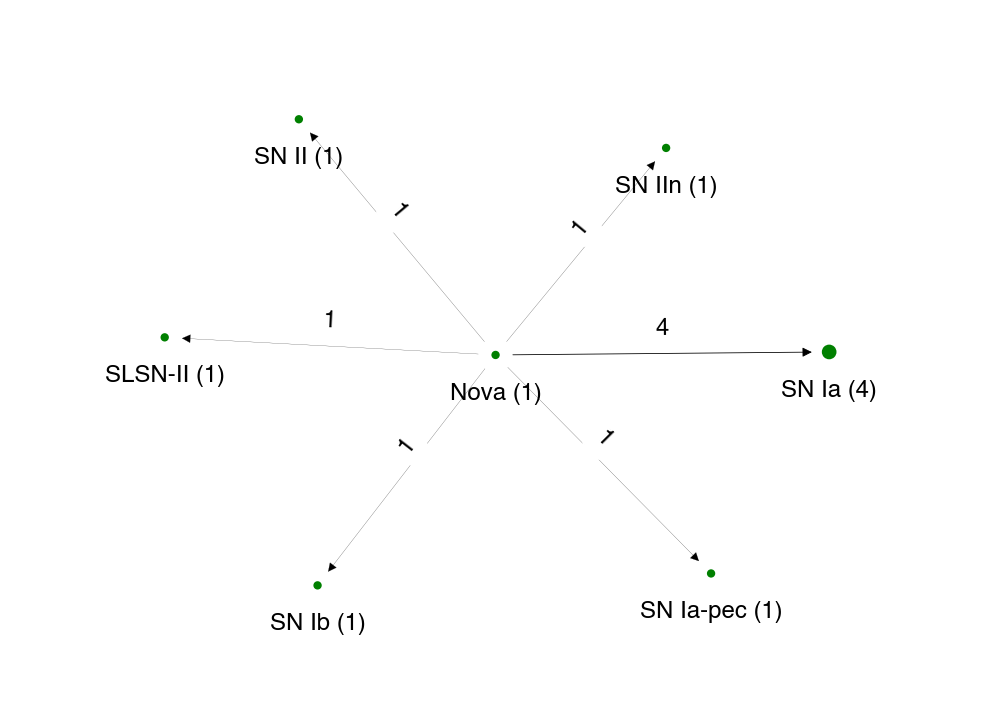

Other


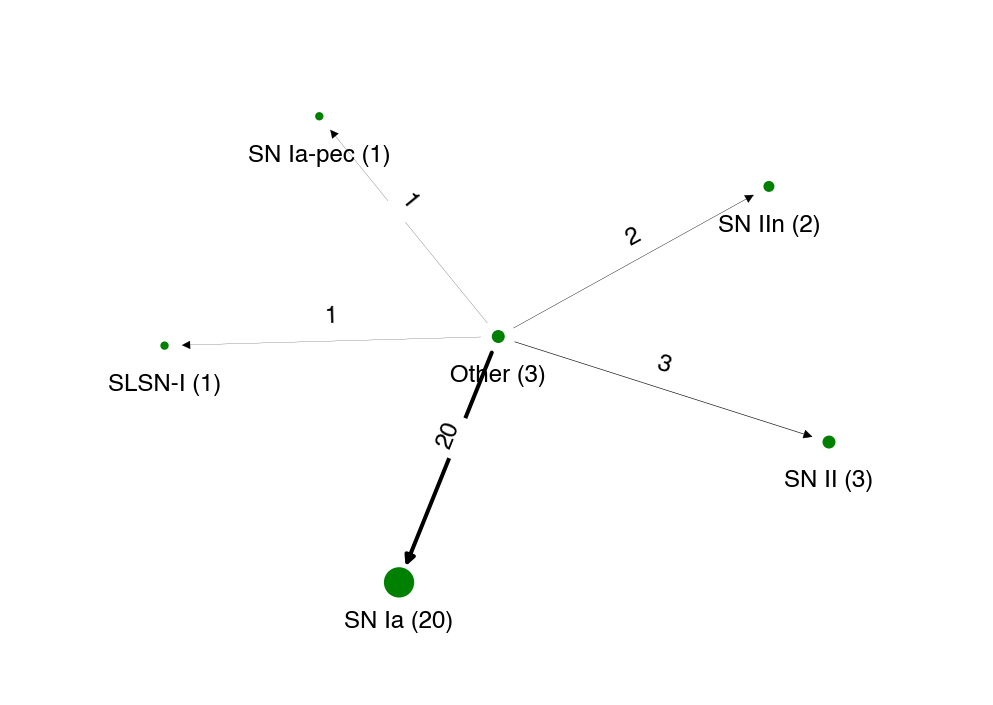

SLSN-I


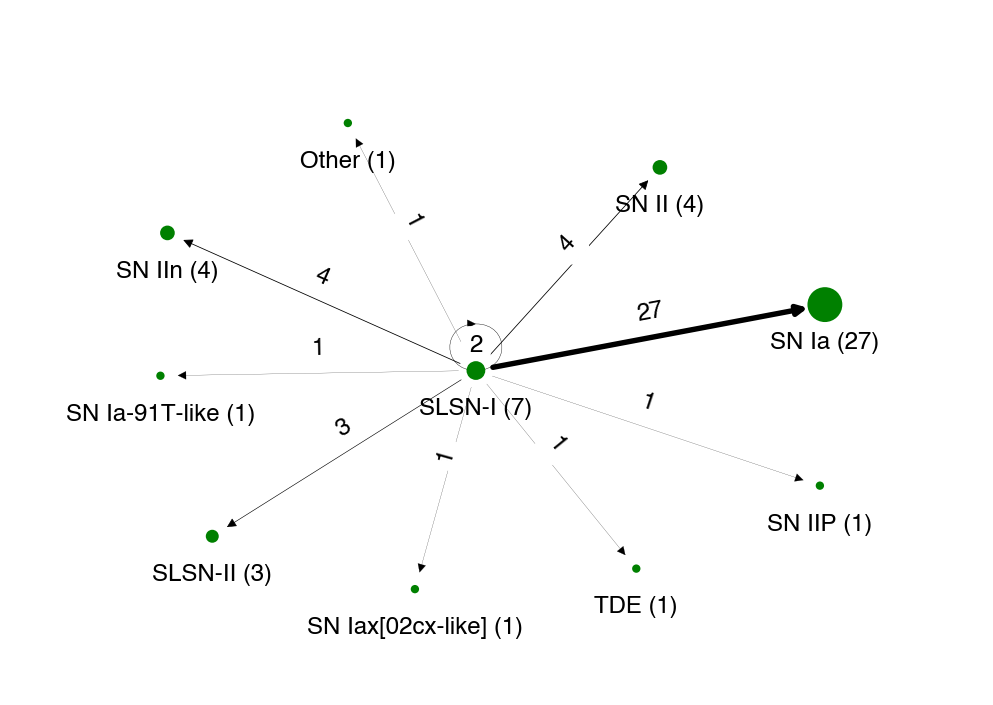

SLSN-II


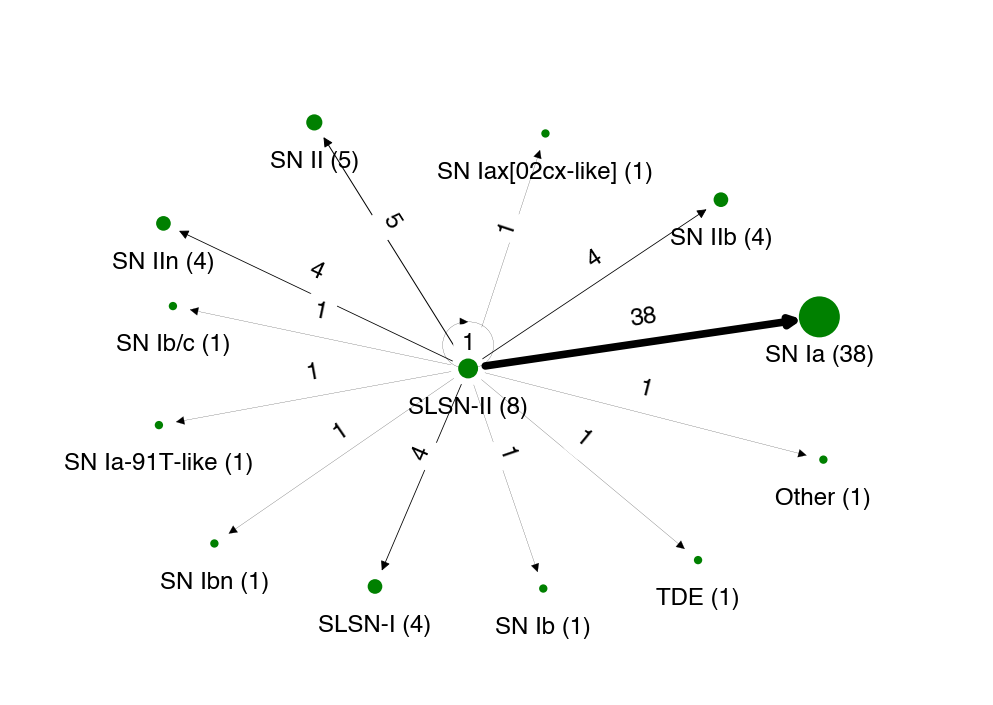

SN


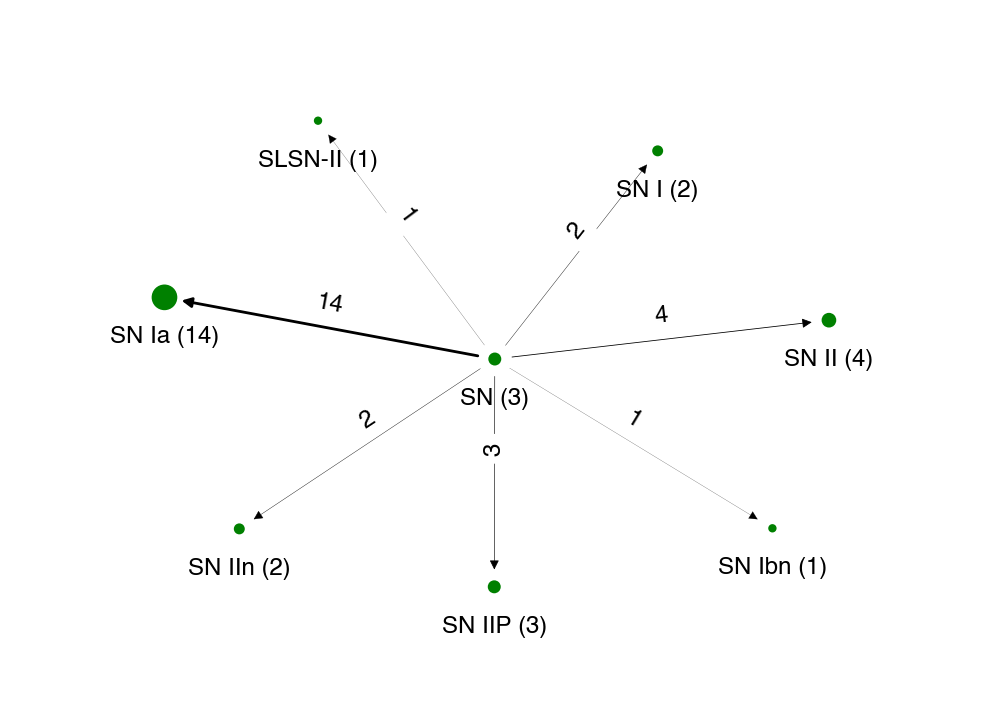

SN I


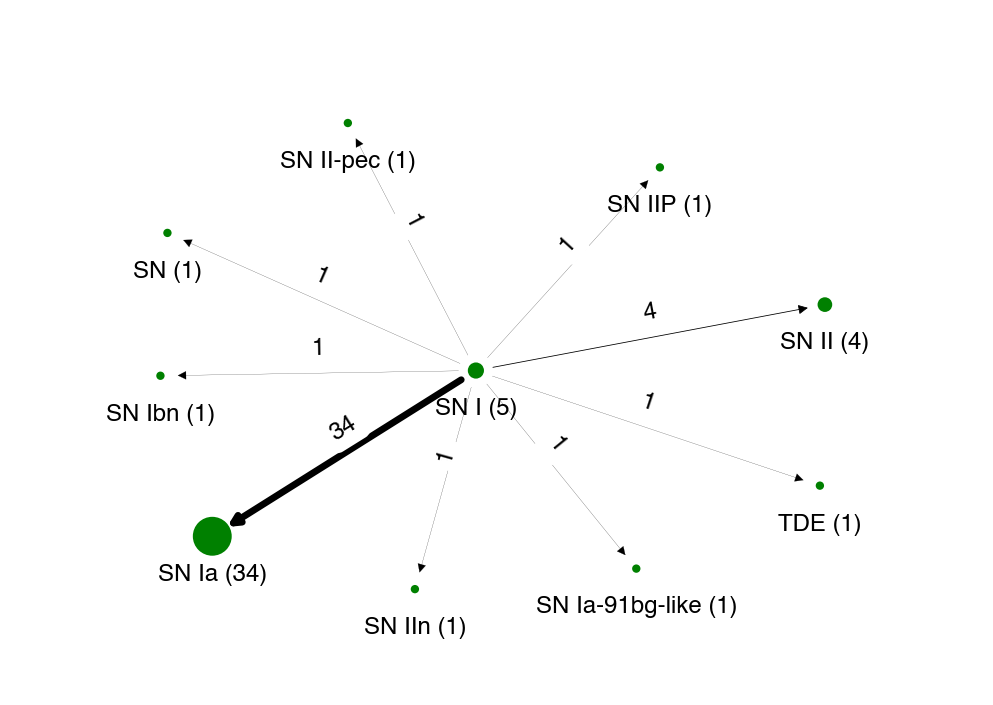

SN II


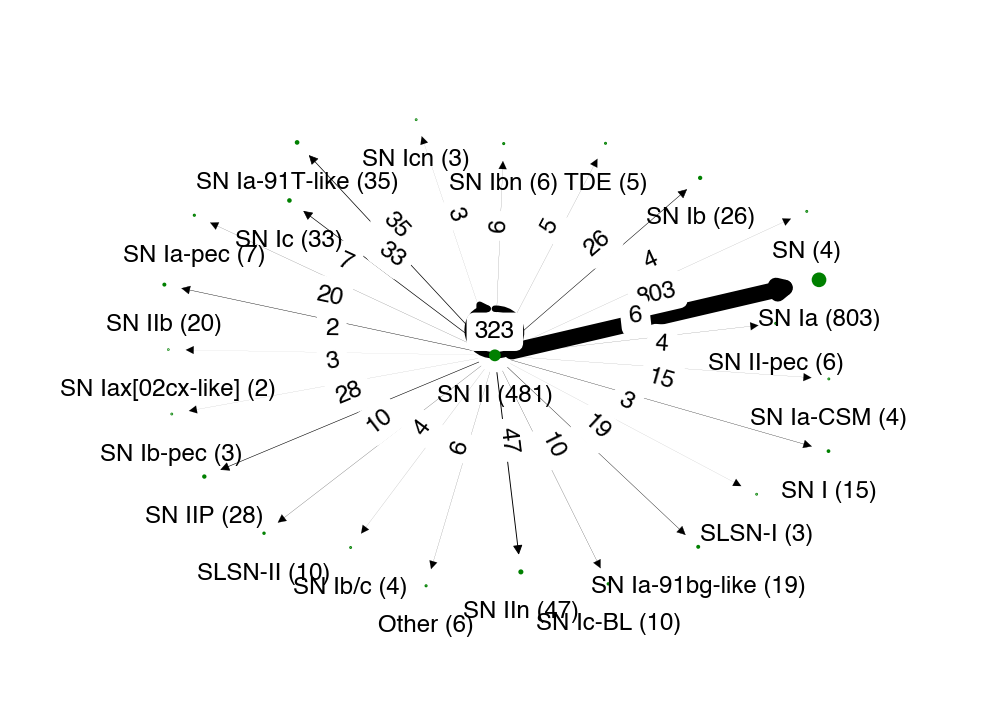

SN II-pec


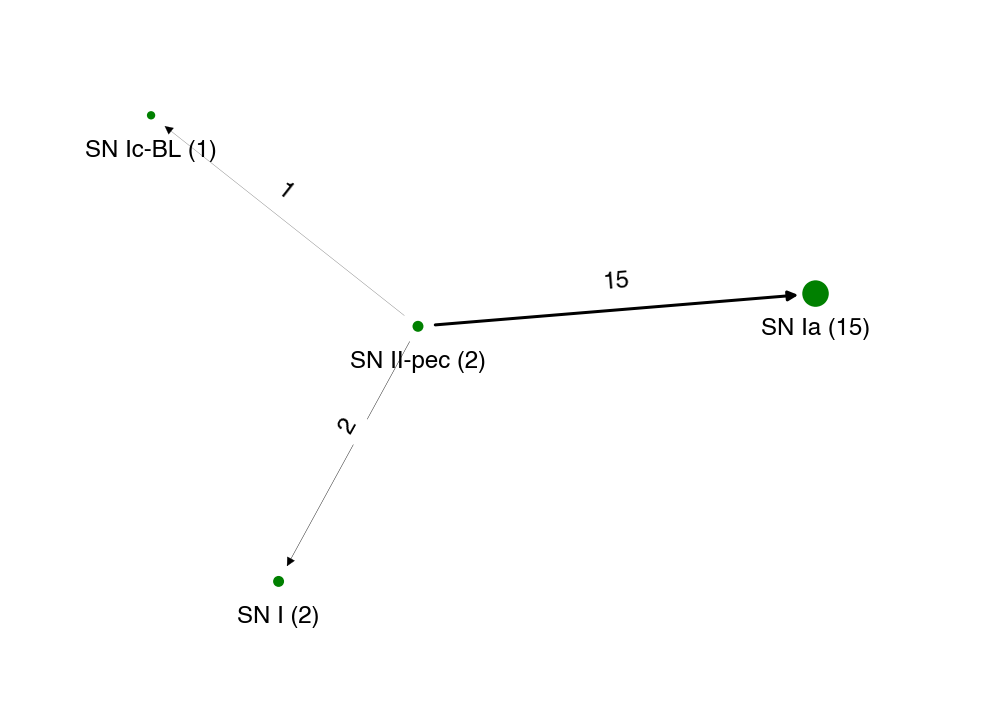

SN IIP


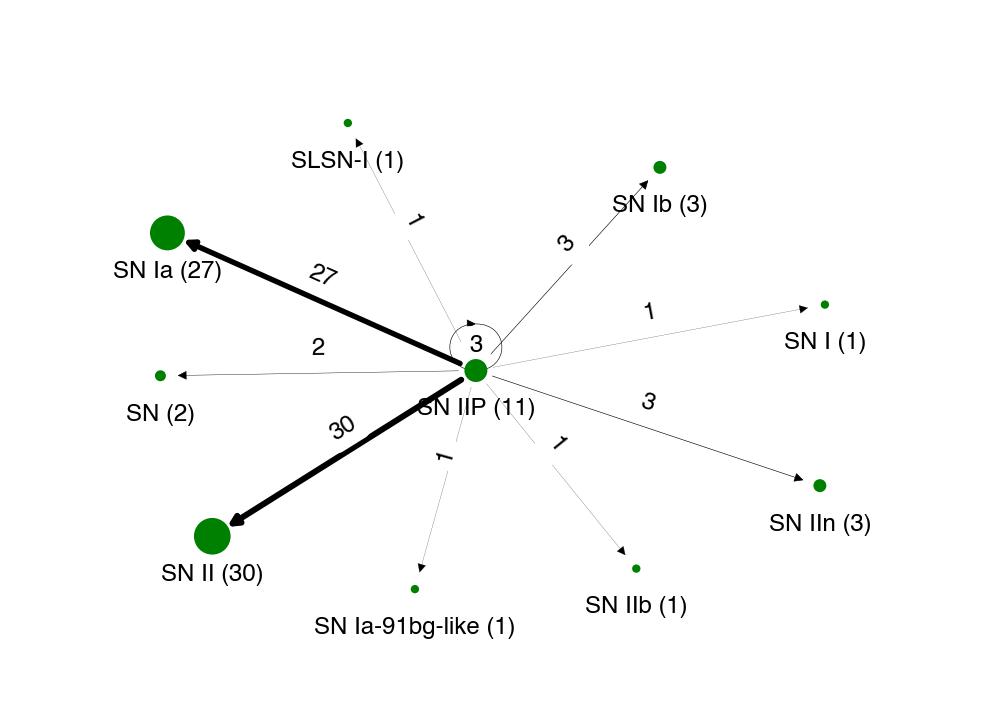

SN IIb


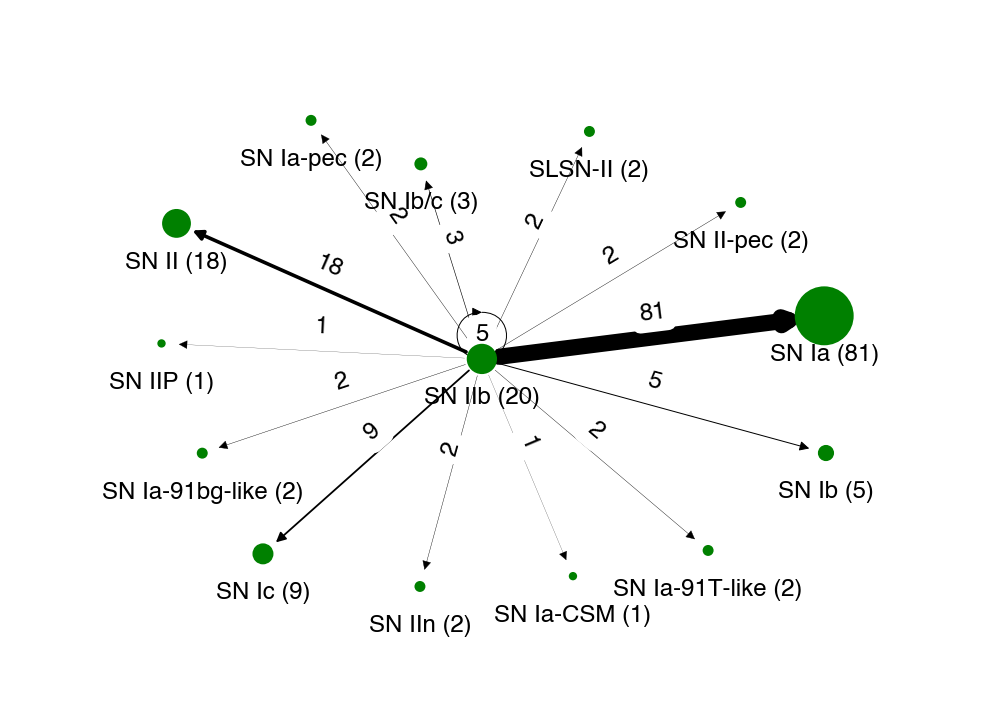

SN IIn


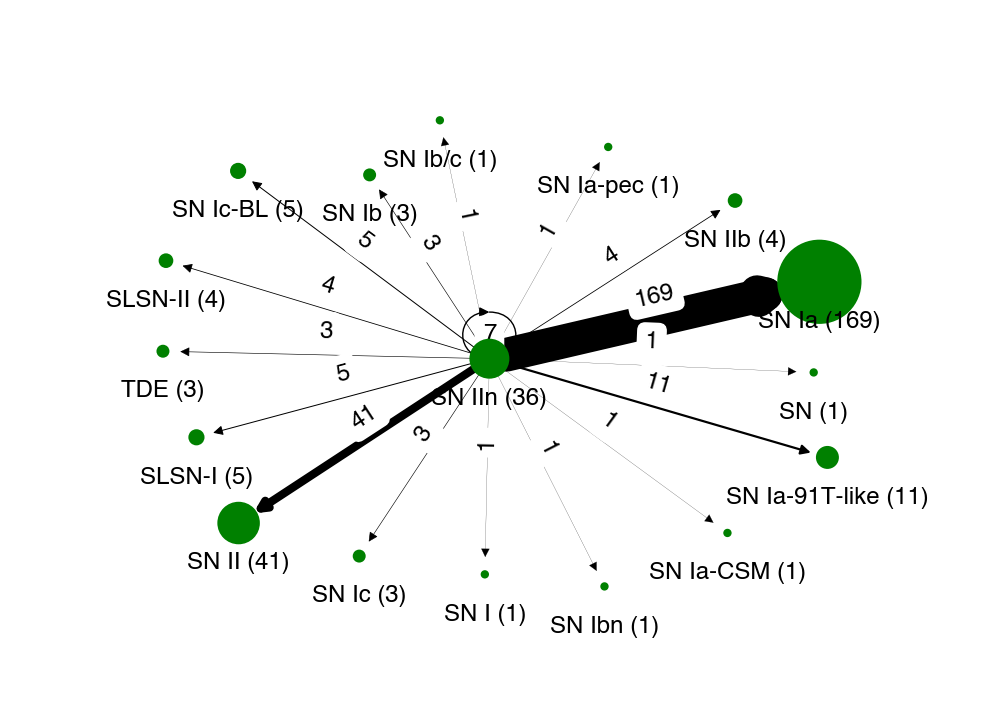

SN Ia


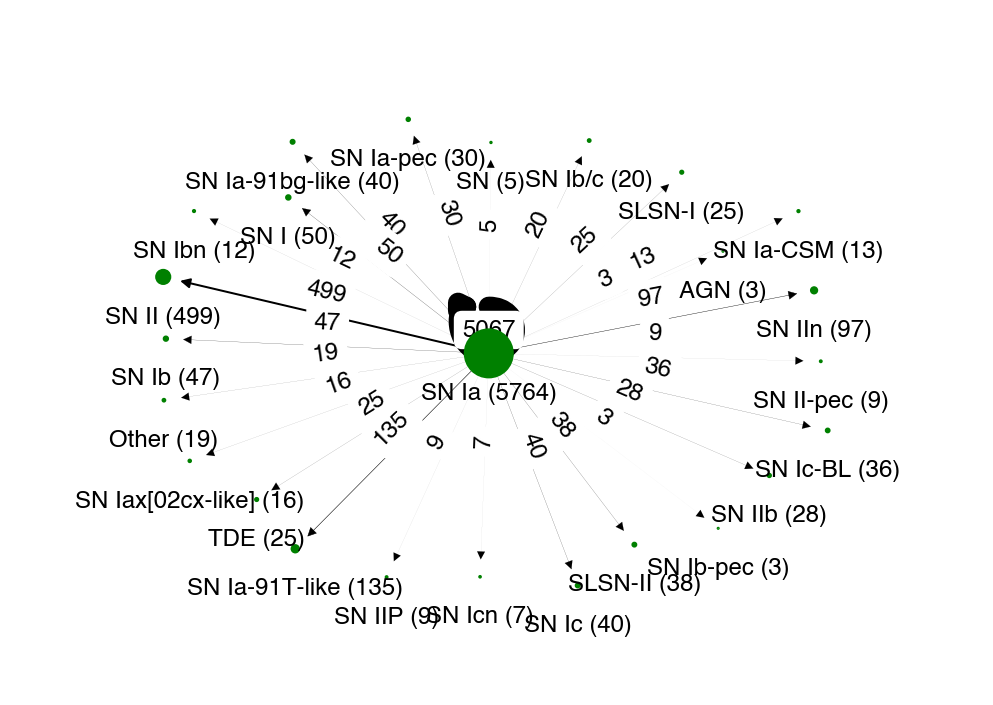

SN Ia-91T-like


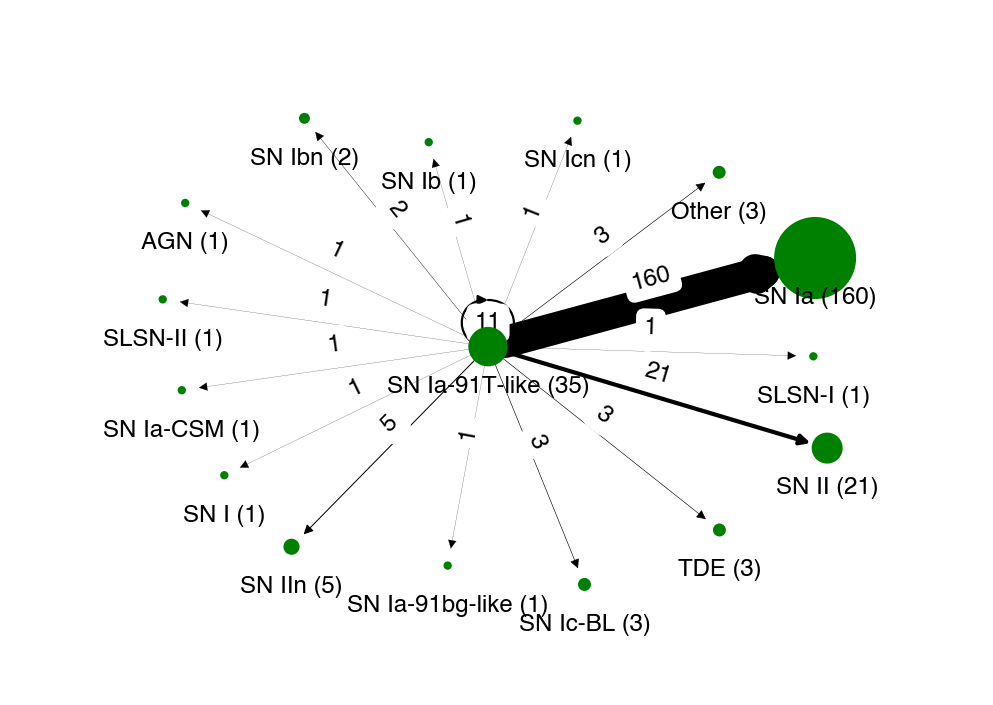

SN Ia-91bg-like


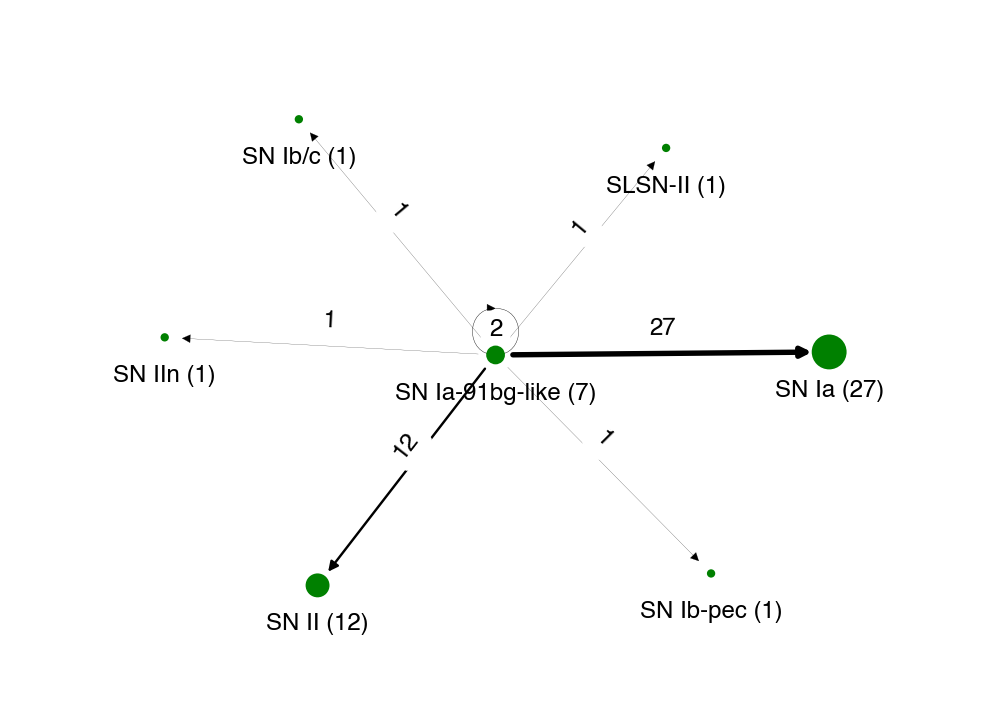

SN Ia-CSM


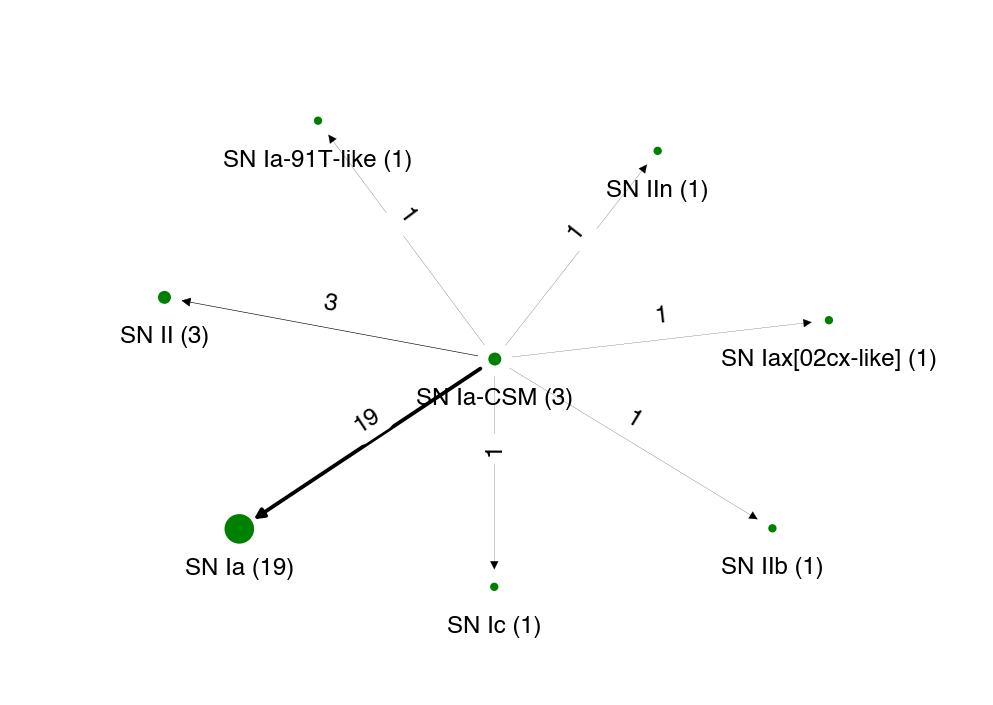

SN Ia-pec


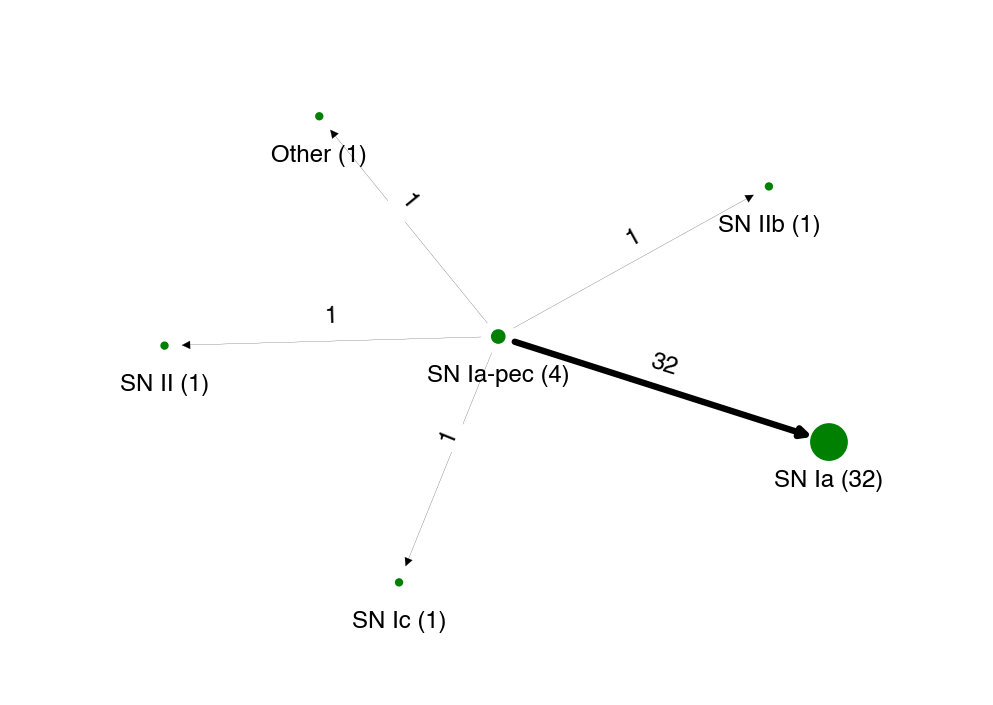

SN Iax[02cx-like]


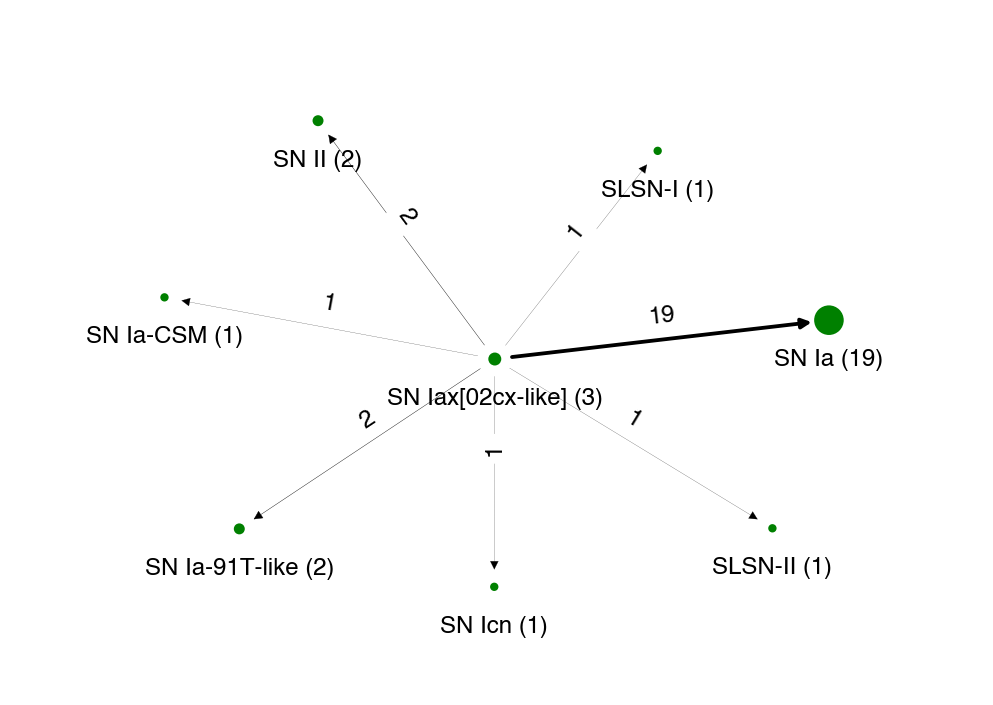

SN Ib


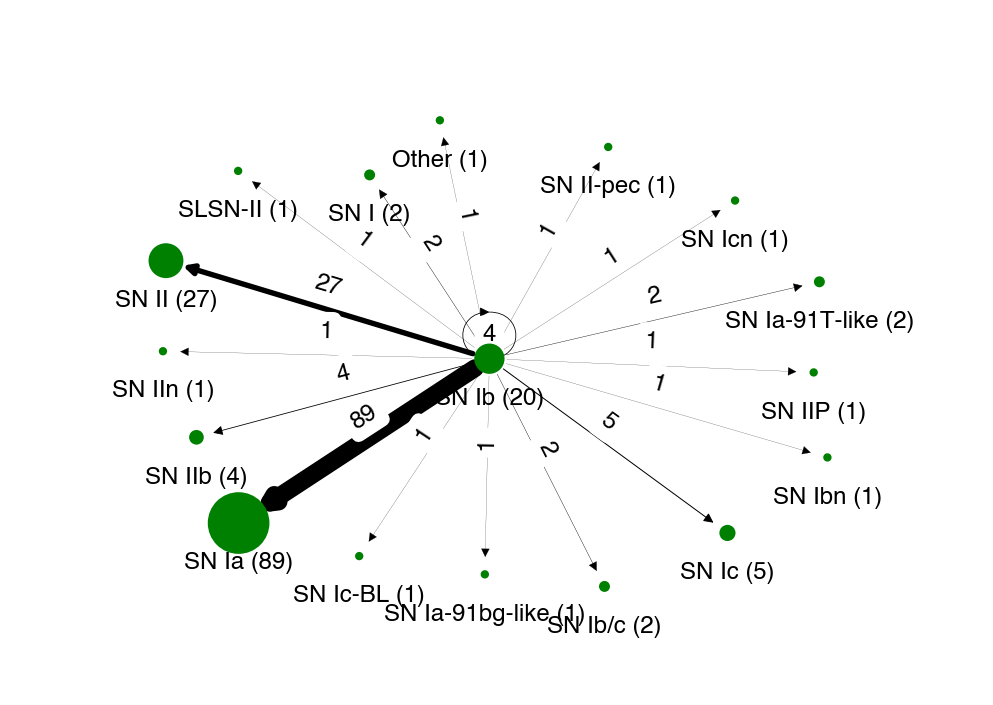

SN Ib-pec


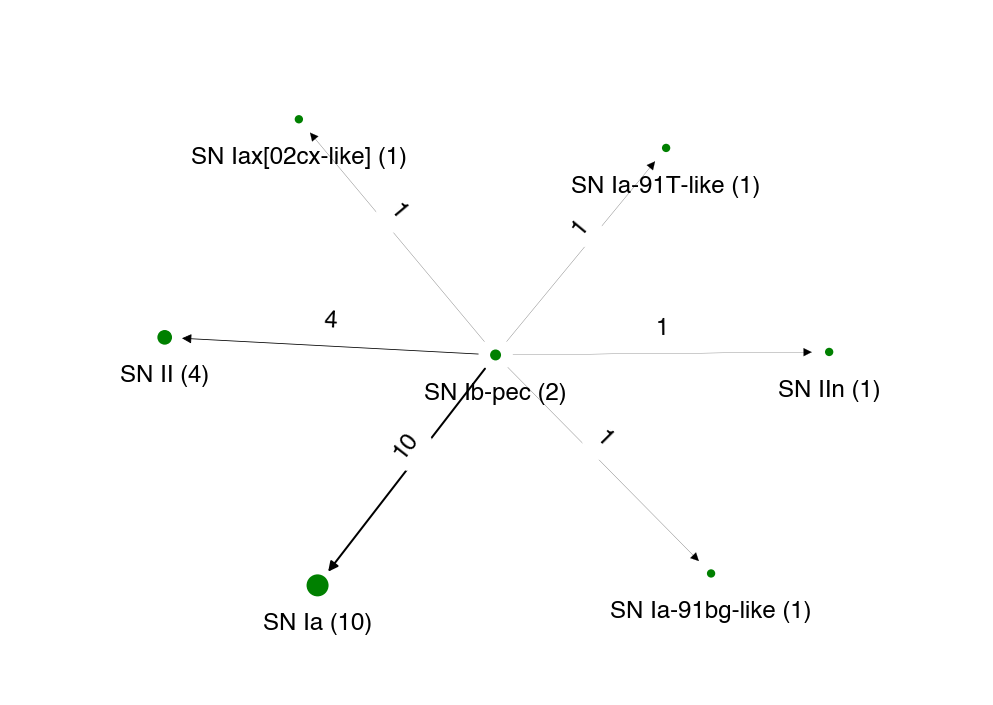

SN Ib/c


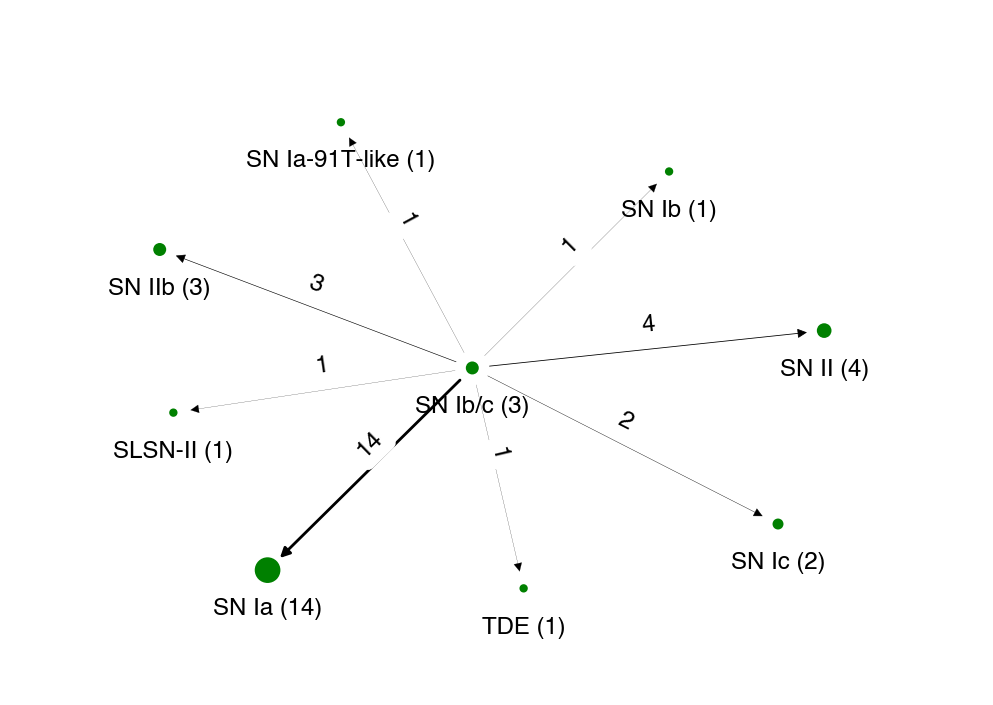

SN Ibn


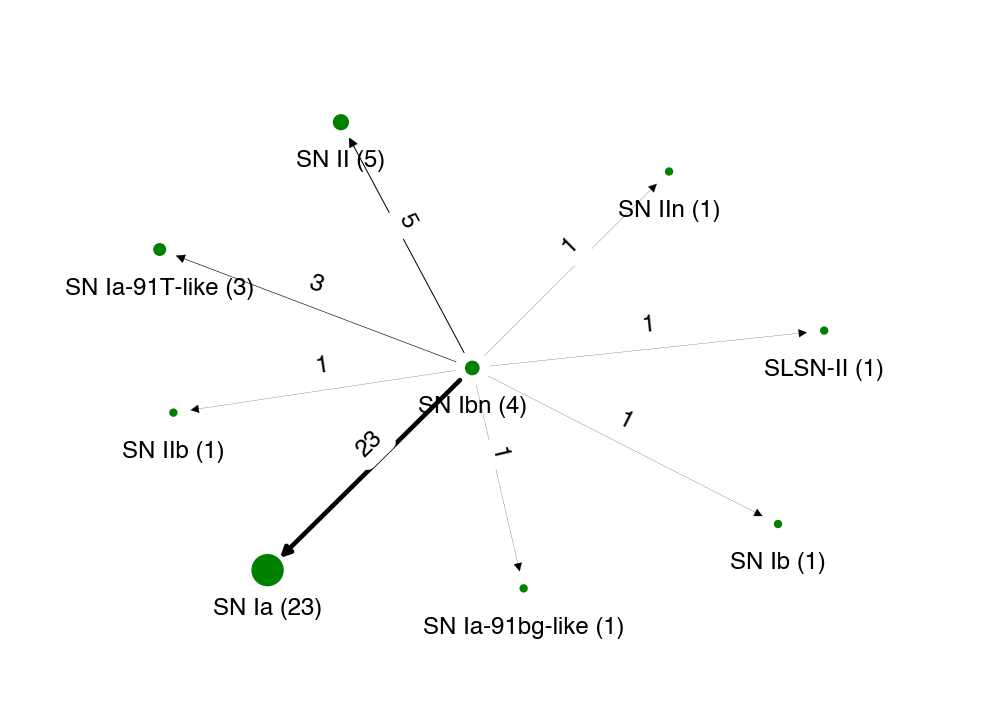

SN Ic


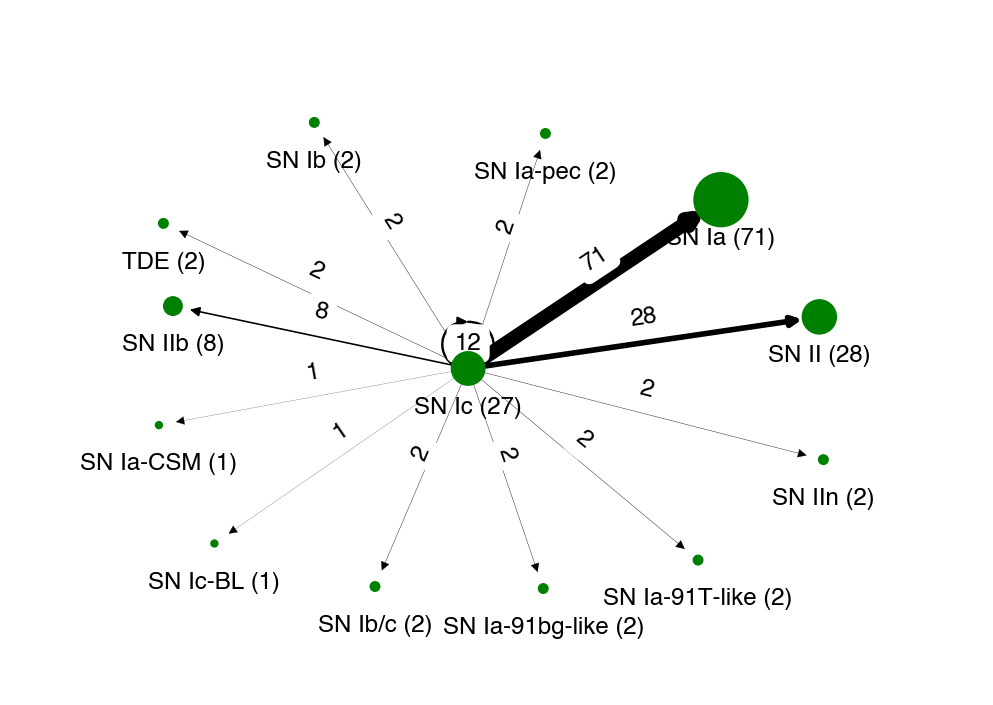

SN Ic-BL


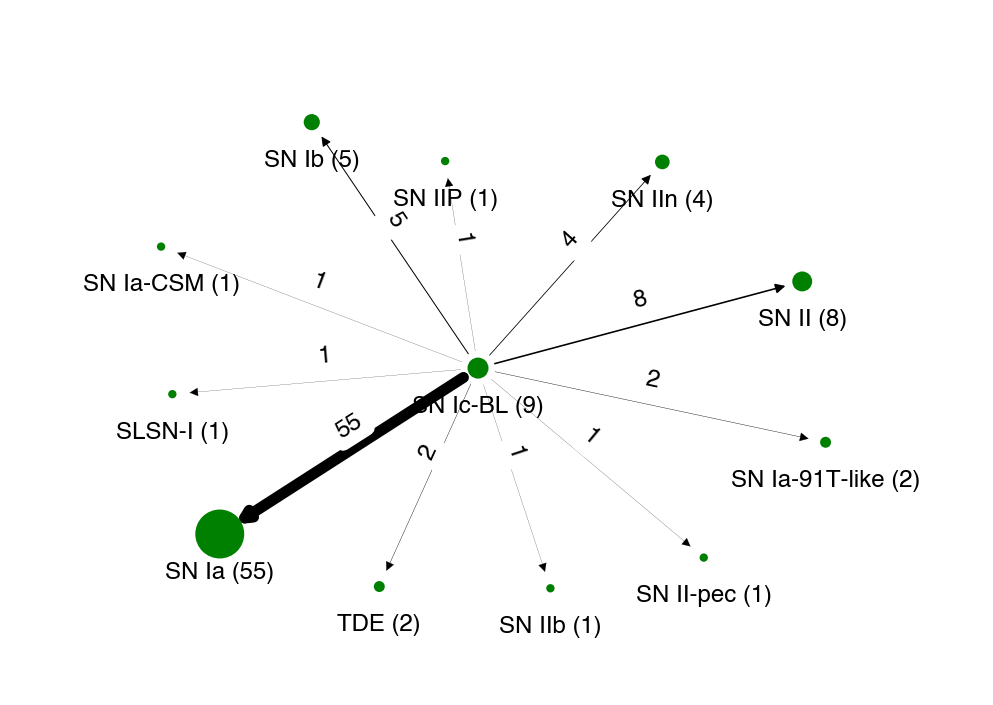

SN Icn


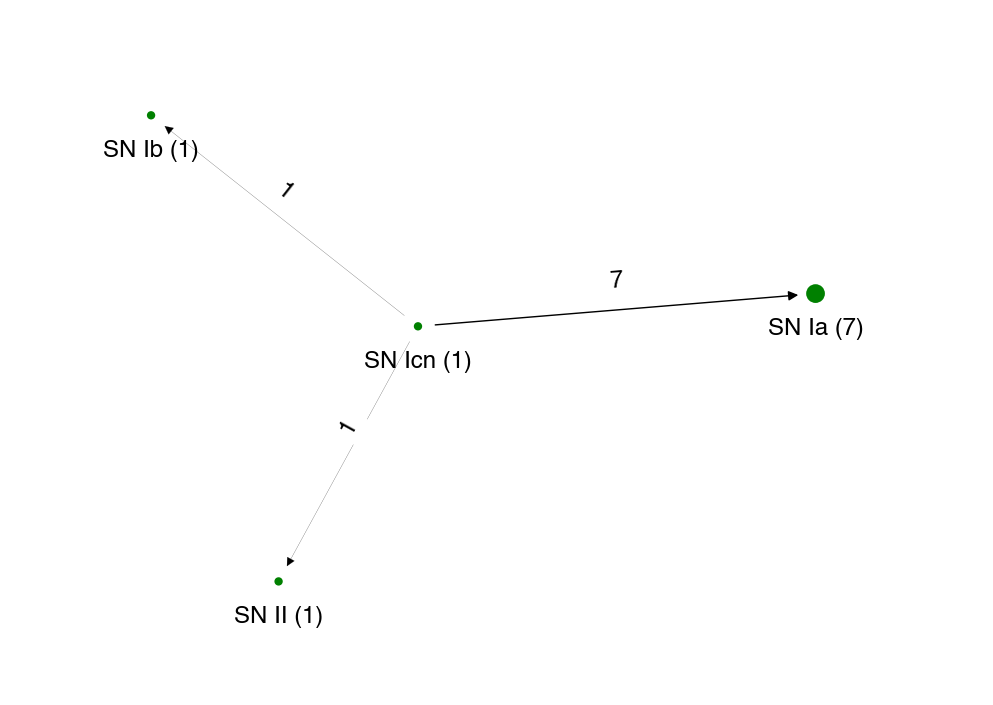

TDE


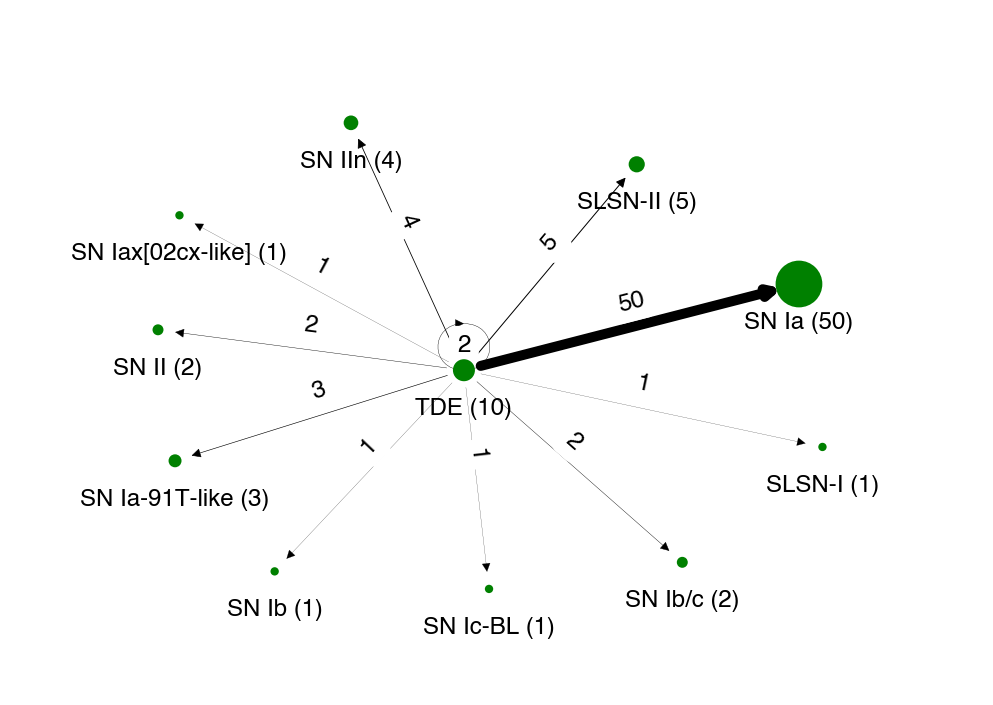

In [94]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

for cls in np.unique(graph_df['node']):
    print(cls)
    
    graph_df_cls = graph_df[graph_df.node == cls]


    # Create a sample dataframe with node and edge data
    df = graph_df_cls
    # Create a list of edges
    edges = [(row['node'], to) for _, row in df.iterrows() for to in row['neighbors']]

    # Create a network graph from the edges
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Compute the frequency of each unique connection
    edge_freq = {}
    for u, v in edges:
        key = (min(u, v), max(u, v))
        edge_freq[key] = edge_freq.get(key, 0) + 1

    # Add edge labels with frequency
    edge_labels = {}
    for u, v, d in G.edges(data=True):
        key = (min(u, v), max(u, v))
        #if edge_freq[key] >= 500:
        edge_labels[(u, v)] = str(edge_freq[key])

        # set edge widths based on frequency
        if cls == 'SN Ia': edge_widths = [int(edge_labels[edge])/500 for edge in edge_labels]
        elif cls == 'SN II': edge_widths = [int(edge_labels[edge])/100 for edge in edge_labels]
        elif cls == 'None': edge_widths = [int(edge_labels[edge])/1000 for edge in edge_labels]
        else: edge_widths = [int(edge_labels[edge])/10 for edge in edge_labels]

        # Scale the node sizes by the occurrences of the node
        #node_sizes = [10 * sum(1 for x in edges if x[0] == node or x[1] == node) for node in G.nodes()]
        #print(node_sizes)

        # explode the lists in the second column into separate rows
        df_expl = df.explode('neighbors')

        # group the data frame by the label column and count the number of unique values for each group
        unique_node_d = dict(Counter(df['node']))
        unique_neighbors_d = dict(Counter(df_expl['neighbors']))

        for key in unique_neighbors_d:
            if key in unique_node_d:
                unique_node_d[key] += unique_neighbors_d[key]
            else:
                unique_node_d[key] = unique_neighbors_d[key]

    node_count = unique_node_d
    
    if cls == 'SN Ia': node_sizes = [node_count[node] * 0.1 for node in G.nodes()]
    elif cls == 'SN II': node_sizes = [node_count[node] * 0.05 for node in G.nodes()]
    elif cls == 'None': node_sizes = [node_count[node] * 0.01 for node in G.nodes()]
    else: node_sizes = [node_count[node] * 10 for node in G.nodes()]
    #print(node_sizes)

    # Plot the graph
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color='g', node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, edge_color='k', width=edge_widths)

    # Move the labels of the nodes down right below the node
    pos_labels = {}
    for key, value in pos.items():
        pos_labels[key] = (value[0], value[1] +.1)


    # # count the number of times of each node 
    # node_count = dict(Counter(graph_df_cv['node']))

    # # scale node sizes by frequency
    # node_sizes = [node_count[node] * 9 for node in G.nodes()]

    # create labels with node and count information
    node_labels = {node: f"\n\n\n\n\n{node} ({node_count[node]})" for node in G.nodes()}

    nx.draw_networkx_labels(G, pos_labels, labels=node_labels, font_size=12, font_color='black')

    nx.draw_networkx_edge_labels(G, pos_labels, edge_labels=edge_labels, font_size=12, font_color='black', font_weight='bold')

    cls = cls.replace(' ', '').replace('/','')
#     plt.axis('off')
#     plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
#     plt.show()

    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.tight_layout()
    plt.savefig(f'../figures/graphs/{suffix}_size_scaled_{cls}.jpg', dpi=300)
    plt.show()
